In [1]:
import sys,os,os.path
sys.path.append("../../../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [2]:
file = 'sophronia_180_208Tl.h5'

soph_file = f'../../../Tl_studies/LPR/208Tl/PORT_1a/prod/sophronia/sophronia/' + str(file)
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,147.725,0.0,0.0,374.378021,7.246377,765.075420,-1.0,0.002455,-1,-1.0
1,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,163.275,0.0,0.0,374.378021,5.043478,532.492472,-1.0,0.001720,-1,-1.0
2,3580000,3.580001e+12,0,-148.667262,364.111673,1,-256.575,147.725,0.0,0.0,374.378021,5.739130,605.939696,-1.0,0.001951,-1,-1.0
3,3580000,3.580001e+12,0,-148.667262,364.111673,1,-256.575,163.275,0.0,0.0,374.378021,5.043478,532.492472,-1.0,0.001721,-1,-1.0
4,3580000,3.580001e+12,0,-148.667262,364.111673,1,-272.125,147.725,0.0,0.0,375.409210,13.159420,597.688660,-1.0,0.001918,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175387,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,132.175,0.0,0.0,695.576599,8.869565,627.508728,-1.0,0.002034,-1,-1.0
175388,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,147.725,0.0,0.0,695.576599,6.260870,442.947357,-1.0,0.001432,-1,-1.0
175389,3580710,3.580712e+12,0,373.853623,76.970409,1,163.275,132.175,0.0,0.0,696.634155,7.072464,723.569092,-1.0,0.002337,-1,-1.0
175390,3580710,3.580712e+12,0,373.853623,76.970409,1,194.375,132.175,0.0,0.0,696.634155,7.188406,735.430908,-1.0,0.002384,-1,-1.0


In [3]:
df_ps = pd.read_hdf(soph_file, 'MC/particles')
# collecting event map
df_em = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')

display(df_ps)
display(df_em)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,1790000,1,Tl208,True,0,396.499481,394.874512,535.593628,0.000000,396.499481,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000e+00,none,RadioactiveDecay
1,1790000,4,e-,False,1,396.499481,394.874512,535.593628,0.000110,398.365997,...,-0.106256,-0.289186,-0.332899,0.000000,0.000000,-0.0000,0.172273,5.370340e+00,RadioactiveDecay,eIoni
2,1790000,3,anti_nu_e,False,1,396.499481,394.874512,535.593628,0.000110,-2433.799561,...,-0.223934,0.957762,-0.531800,-0.223934,0.957762,-0.5318,1.118153,1.413230e+04,RadioactiveDecay,Transportation
3,1790000,2,Pb208[3708.451],False,1,396.499481,394.874512,535.593628,0.000110,396.499481,...,0.330191,-0.668577,0.864701,0.000000,-0.000000,0.0000,0.000003,0.000000e+00,RadioactiveDecay,RadioactiveDecay
4,1790000,6,gamma,False,2,396.499481,394.874512,535.593628,0.000110,394.506500,...,-0.061901,-0.367403,-0.349340,-0.000000,-0.000000,-0.0000,0.510739,1.119218e+02,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28399,1790355,58,e-,False,54,458.691437,445.811005,520.643372,0.280688,458.699463,...,0.927290,-0.043233,-0.477662,-0.000000,0.000000,-0.0000,0.651334,4.838984e-01,compt,eIoni
28400,1790355,57,e-,False,54,457.540802,445.214691,521.664978,0.275183,457.540802,...,-0.005090,0.002766,-0.000693,0.000000,0.000000,-0.0000,0.000033,1.218642e-07,compt,msc
28401,1790355,56,e-,False,54,457.540802,445.214691,521.664978,0.275183,457.538544,...,0.237928,0.011487,0.190811,-0.000000,0.000000,-0.0000,0.084207,2.260339e-02,compt,eIoni
28402,1790355,55,e-,False,54,427.394226,432.870880,537.013123,0.155065,427.611664,...,0.607127,1.560446,0.571284,-0.000000,0.000000,0.0000,1.330490,1.041581e+00,compt,eIoni


,evt_number
nexus_evt,
1790000,3580000
1790001,3580002
1790002,3580004
1790003,3580006
1790004,3580008
...,...
1790351,3580702
1790352,3580704
1790353,3580706


In [4]:
eventmap_reset = df_em.reset_index()


# alter nexus evt to evt number to match
if not (eventmap_reset['nexus_evt'] * 2 == eventmap_reset['evt_number']).all():
    print("Falses in here! nexus event and event number are not aligned as expected")
else:
    print("No Falses to be seen! Matching. DONT RUN MORE THAN ONCE")
    df_ps['event_id'] = df_ps['event_id'] * 2 
    



No Falses to be seen! Matching. DONT RUN MORE THAN ONCE


In [5]:
# choose event
evt_no = 0
evt  = soph_hdst.event.unique()[evt_no]

print(evt)

3580000


In [6]:

soph_evt = soph_hdst[soph_hdst.event == evt]

z_slice = soph_evt.groupby(['Z']).apply(lambda x: len(x))#E.nunique()

In [7]:
print(z_slice)
print(len(z_slice))

Z
374.378021     4
375.409210     4
376.449799     7
377.484100    11
378.526886    13
              ..
521.294067     9
522.332336    10
523.373657     8
524.413391     6
525.453491     3
Length: 65, dtype: int64
65


Text(0.5, 1.0, 'WRONG PLOT sophronia_180_208Tl.h5 event 3580000')

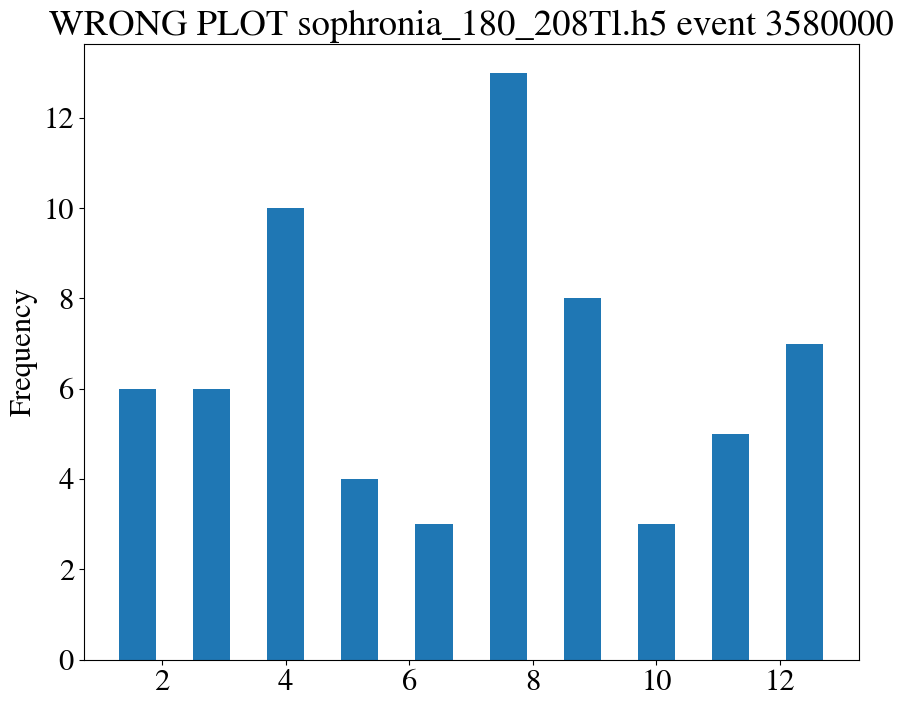

In [8]:
z_slice.plot.hist(rwidth = 0.5)
plt.title('WRONG PLOT ' + file + " event " + str(evt))

Float64Index([ 374.3780212402344,  375.4092102050781,  376.4497985839844,
               377.4841003417969,  378.5268859863281,  379.5603332519531,
               380.5962219238281, 381.64129638671875, 382.67962646484375,
               383.7163391113281,  384.7488708496094,  385.8249816894531,
              388.00201416015625, 389.02911376953125,    390.07861328125,
               391.1383361816406,  392.1698913574219,  393.2093811035156,
               394.2601318359375, 395.30926513671875,  396.3561096191406,
                397.395751953125,    398.44970703125,   399.508544921875,
               400.5331115722656,  401.6061096191406,  402.6313781738281,
              404.75286865234375, 405.80328369140625,  407.9120788574219,
              408.95880126953125,   410.027099609375, 411.08001708984375,
              412.12164306640625, 413.17193603515625,  414.2049560546875,
               415.2507629394531,  416.3237609863281,  417.3966064453125,
                418.425048828125, 419.

Text(0.5, 1.0, 'sophronia_180_208Tl.h5 event 3580000')

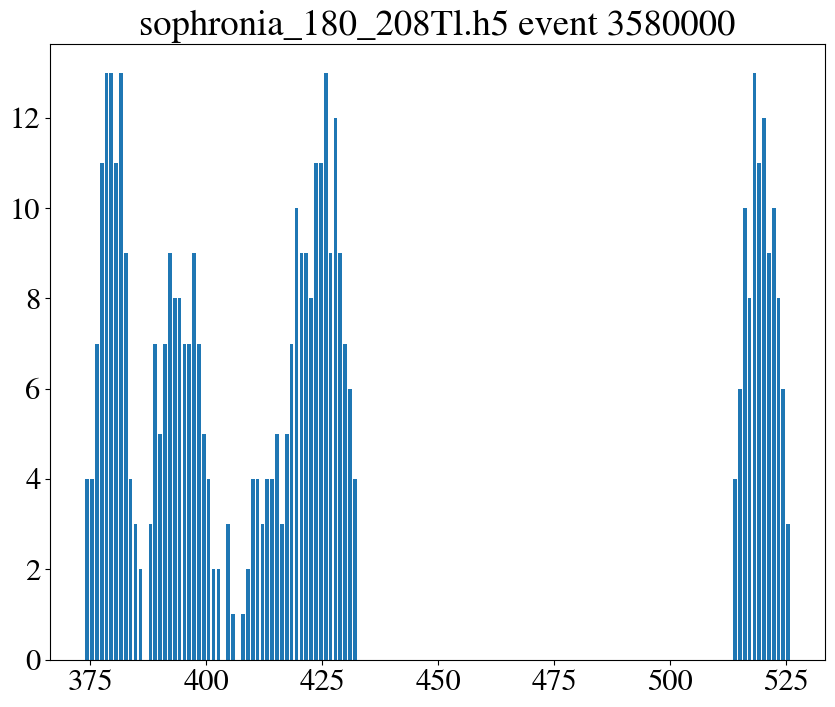

In [9]:
#print(z_slice)
#print(z_slice.max())
print(z_slice.index)
print(z_slice.values)
plt.bar(z_slice.index, z_slice.values)
plt.title(file + " event " + str(evt))

### Create looping thing that collects min and max frequency per event

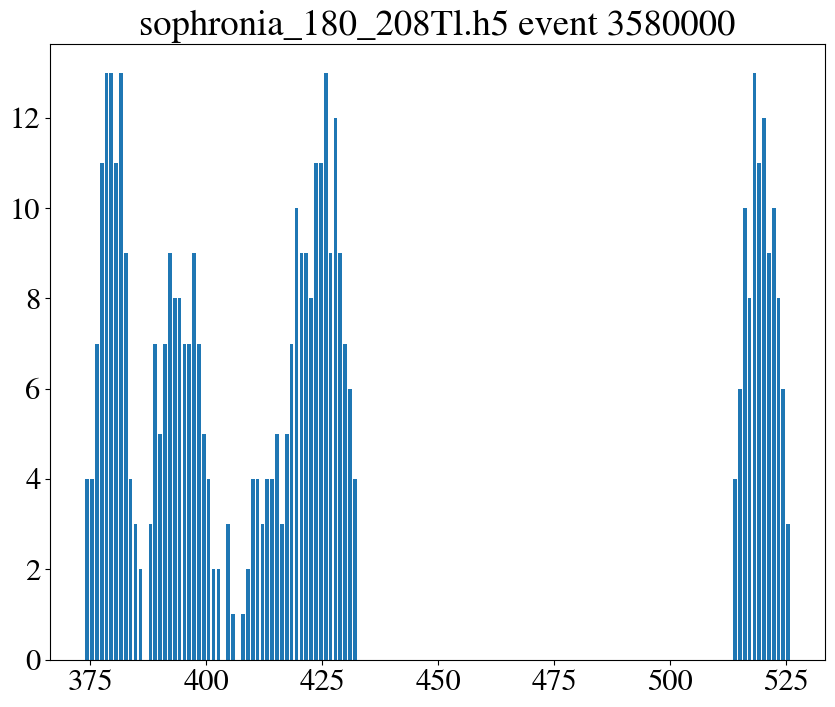

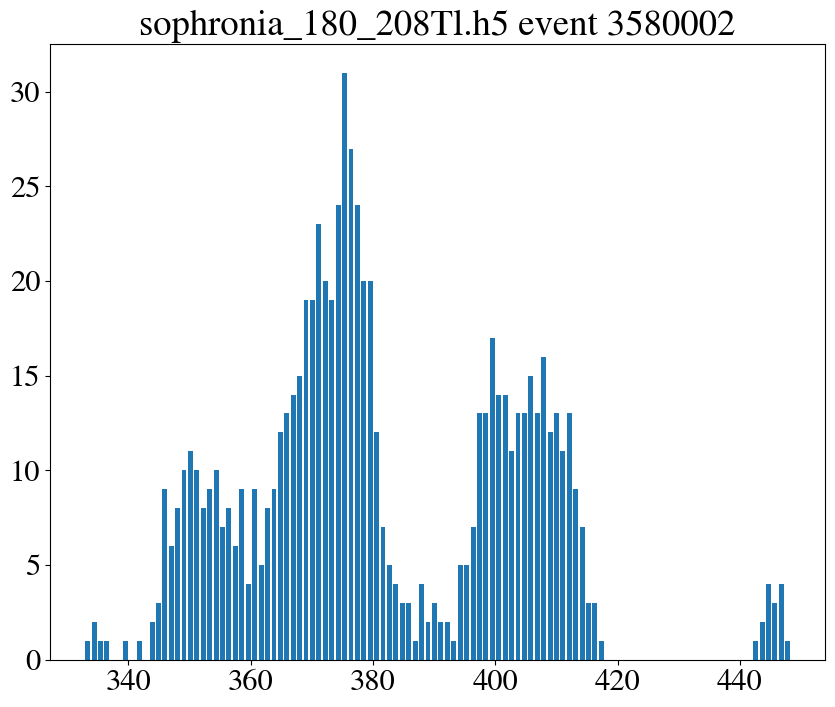

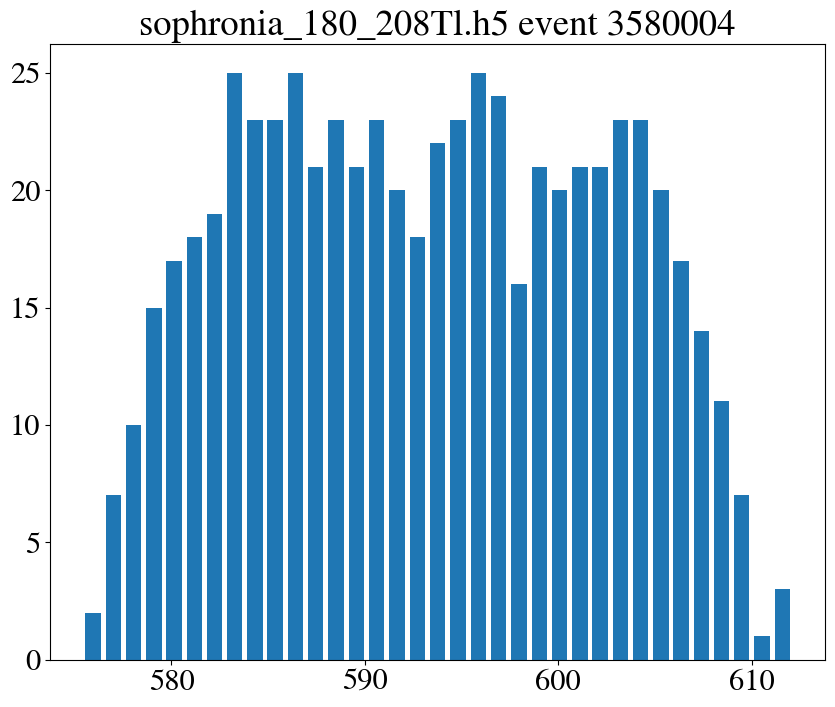

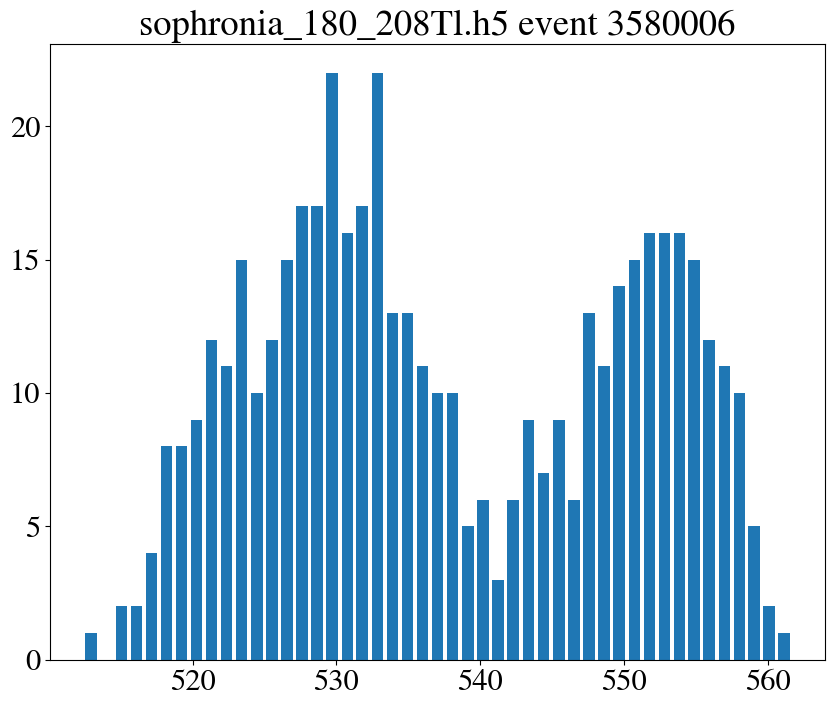

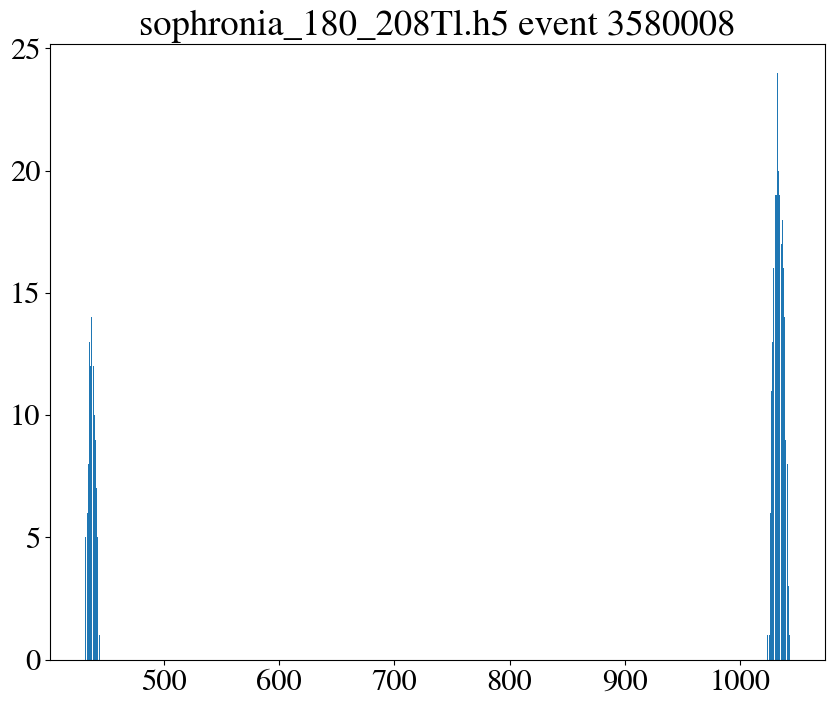

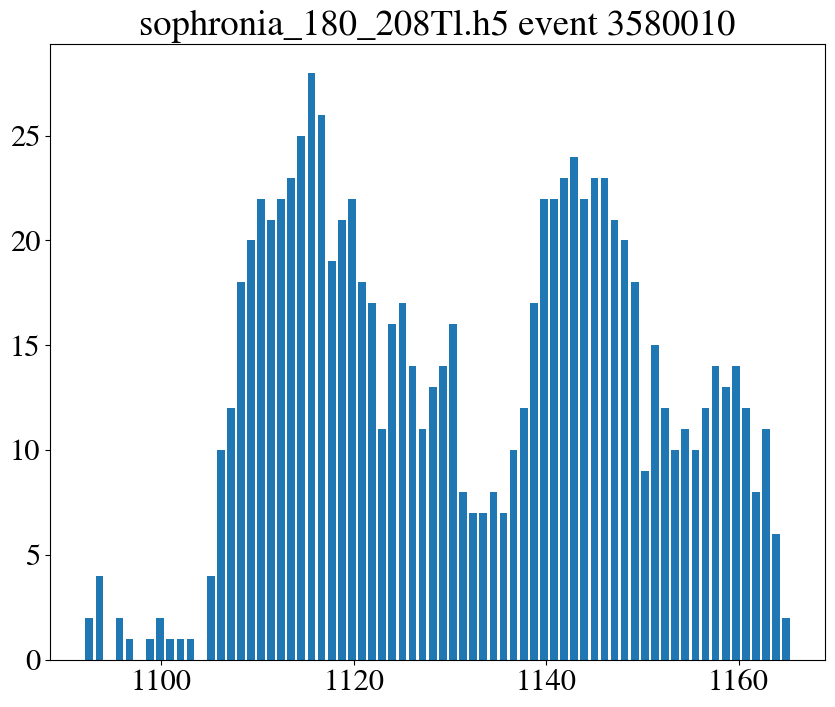

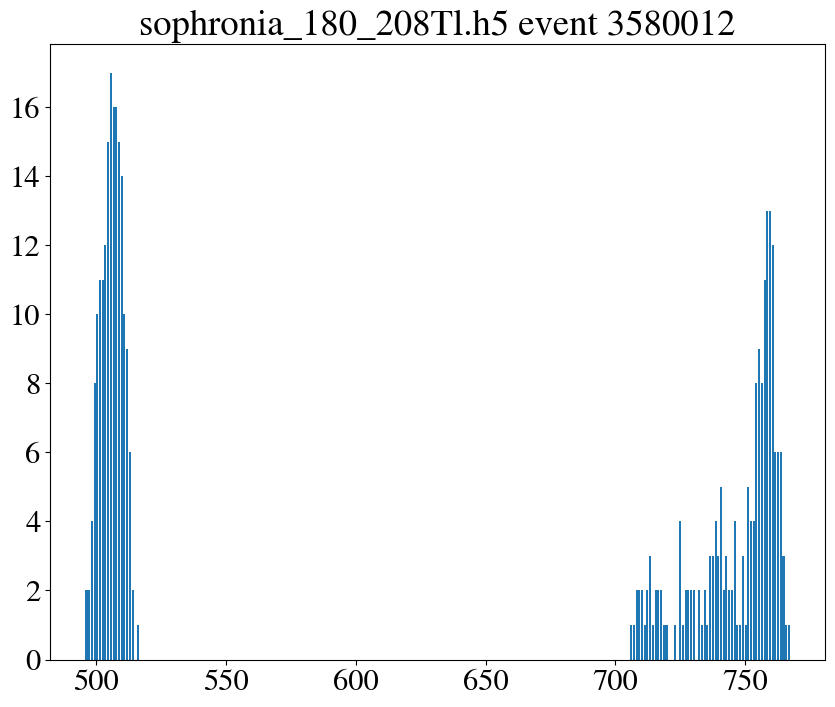

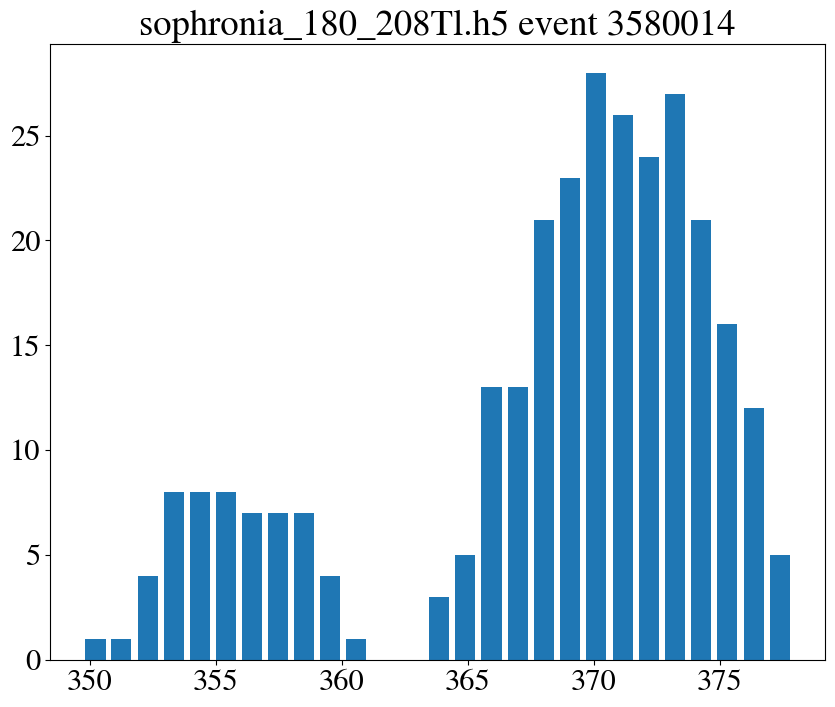

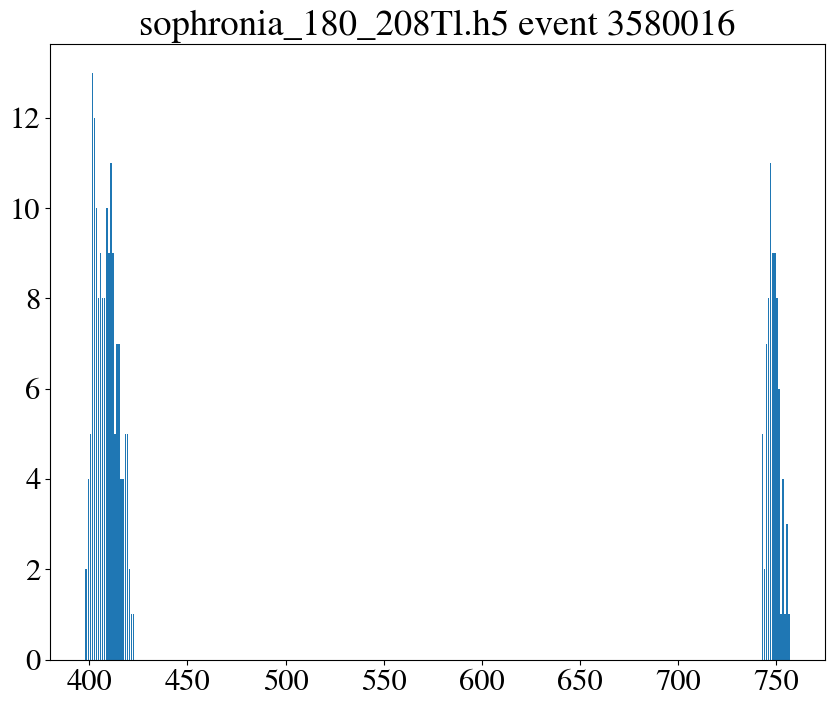

In [10]:
q = 0
limit = 10

for i in range(len(soph_hdst.event.unique())):
    q +=1
    if (q == limit):
        break
    
    evt  = soph_hdst.event.unique()[i]
    
    soph_evt = soph_hdst[soph_hdst.event == evt]

    z_slice = soph_evt.groupby(['Z']).apply(lambda x: len(x))#E.nunique()

    plt.bar(z_slice.index, z_slice.values)
    plt.title(file + " event " + str(evt))
    plt.show()

### collect true MC to only plot double escape peak events


In [12]:
display(df_ps)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,3580000,1,Tl208,True,0,396.499481,394.874512,535.593628,0.000000,396.499481,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000e+00,none,RadioactiveDecay
1,3580000,4,e-,False,1,396.499481,394.874512,535.593628,0.000110,398.365997,...,-0.106256,-0.289186,-0.332899,0.000000,0.000000,-0.0000,0.172273,5.370340e+00,RadioactiveDecay,eIoni
2,3580000,3,anti_nu_e,False,1,396.499481,394.874512,535.593628,0.000110,-2433.799561,...,-0.223934,0.957762,-0.531800,-0.223934,0.957762,-0.5318,1.118153,1.413230e+04,RadioactiveDecay,Transportation
3,3580000,2,Pb208[3708.451],False,1,396.499481,394.874512,535.593628,0.000110,396.499481,...,0.330191,-0.668577,0.864701,0.000000,-0.000000,0.0000,0.000003,0.000000e+00,RadioactiveDecay,RadioactiveDecay
4,3580000,6,gamma,False,2,396.499481,394.874512,535.593628,0.000110,394.506500,...,-0.061901,-0.367403,-0.349340,-0.000000,-0.000000,-0.0000,0.510739,1.119218e+02,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28399,3580710,58,e-,False,54,458.691437,445.811005,520.643372,0.280688,458.699463,...,0.927290,-0.043233,-0.477662,-0.000000,0.000000,-0.0000,0.651334,4.838984e-01,compt,eIoni
28400,3580710,57,e-,False,54,457.540802,445.214691,521.664978,0.275183,457.540802,...,-0.005090,0.002766,-0.000693,0.000000,0.000000,-0.0000,0.000033,1.218642e-07,compt,msc
28401,3580710,56,e-,False,54,457.540802,445.214691,521.664978,0.275183,457.538544,...,0.237928,0.011487,0.190811,-0.000000,0.000000,-0.0000,0.084207,2.260339e-02,compt,eIoni
28402,3580710,55,e-,False,54,427.394226,432.870880,537.013123,0.155065,427.611664,...,0.607127,1.560446,0.571284,-0.000000,0.000000,0.0000,1.330490,1.041581e+00,compt,eIoni


In [17]:
# collect events that have positrons in them
posi_events = df_ps.loc[df_ps['particle_name' ] == 'e+']['event_id'].to_numpy()
display(posi_events)

array([3580004, 3580040, 3580068, 3580106, 3580108, 3580116, 3580140,
       3580148, 3580152, 3580162, 3580170, 3580184, 3580222, 3580232,
       3580246, 3580254, 3580260, 3580280, 3580284, 3580288, 3580322,
       3580340, 3580354, 3580358, 3580372, 3580374, 3580384, 3580388,
       3580416, 3580418, 3580460, 3580470, 3580472, 3580490, 3580534,
       3580546, 3580554, 3580560, 3580568, 3580580, 3580588, 3580594,
       3580598, 3580600, 3580610, 3580626, 3580634, 3580674, 3580680,
       3580708])

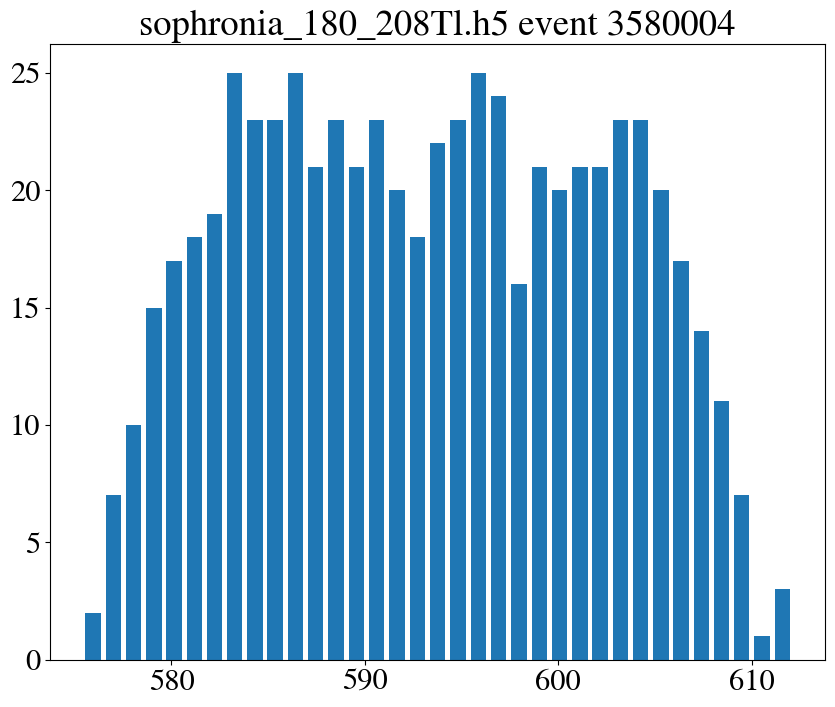

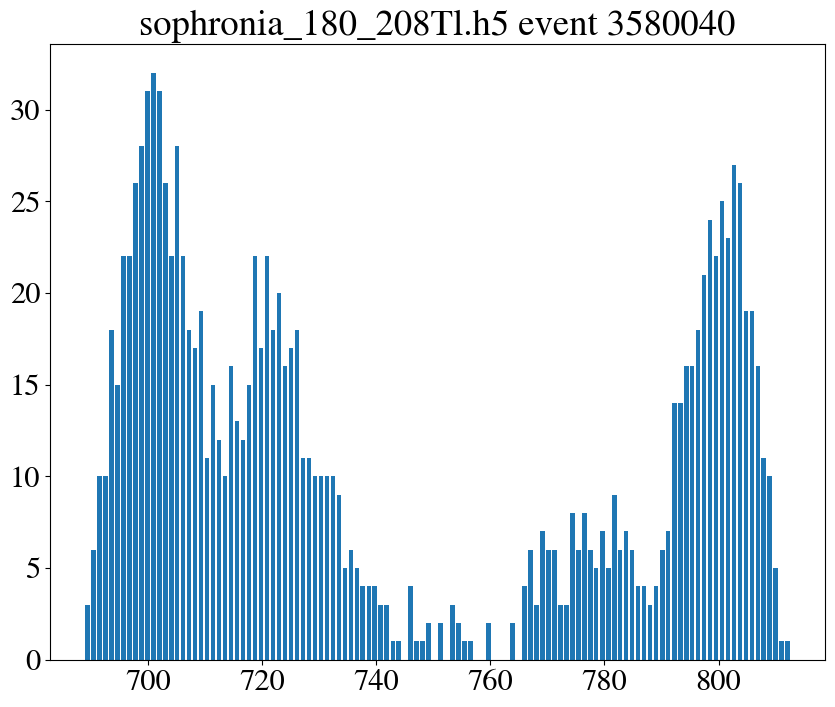

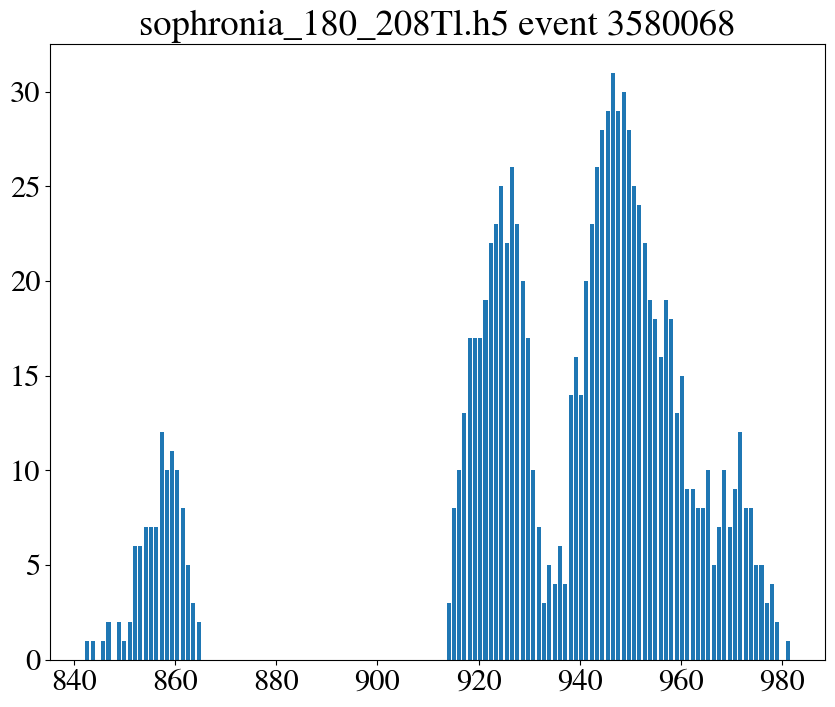

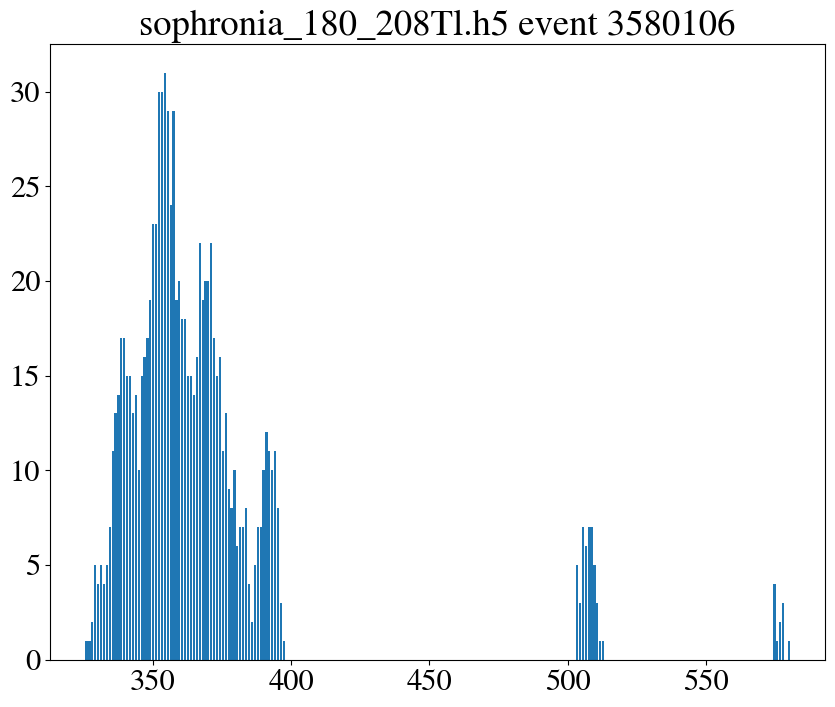

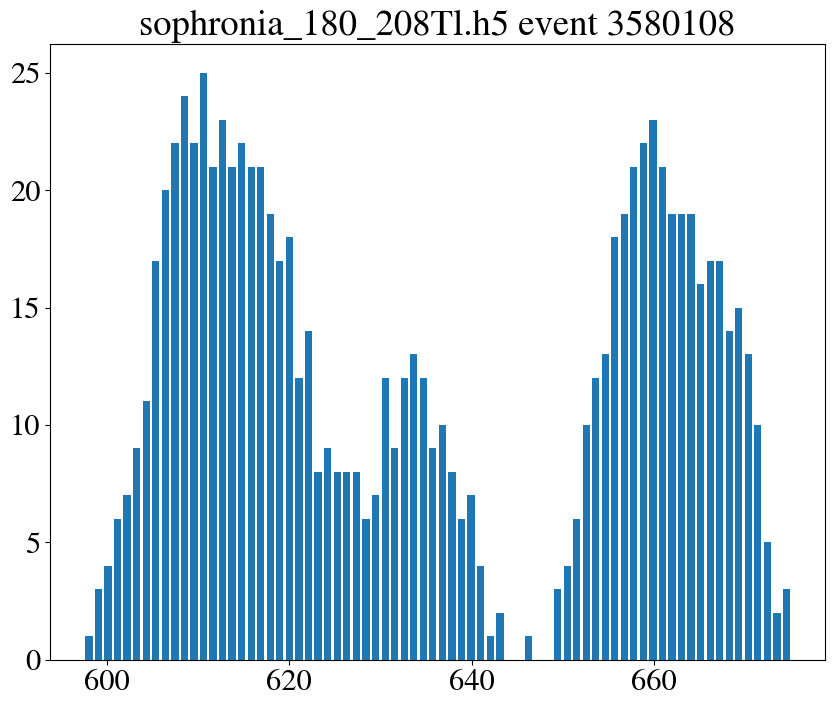

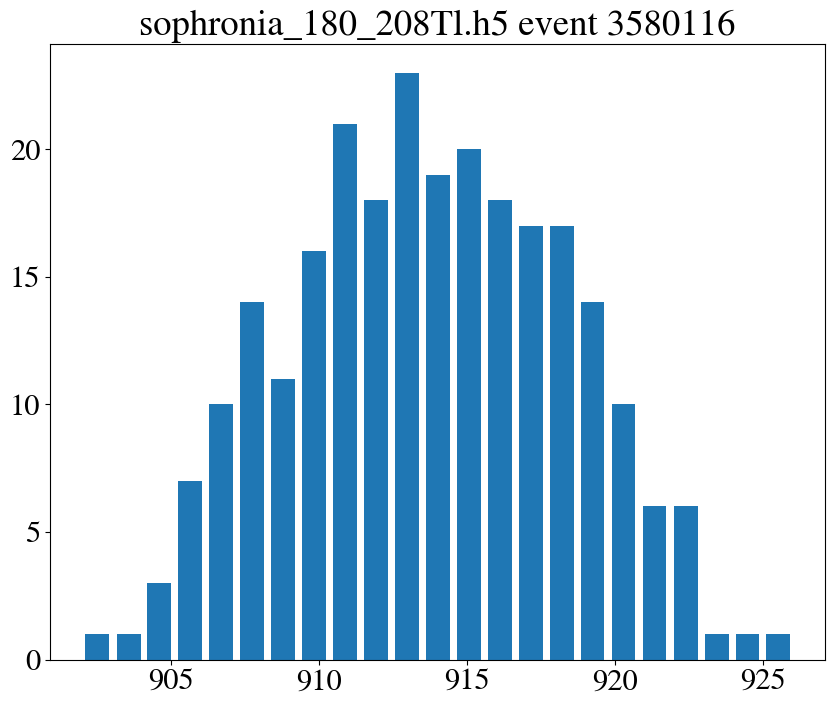

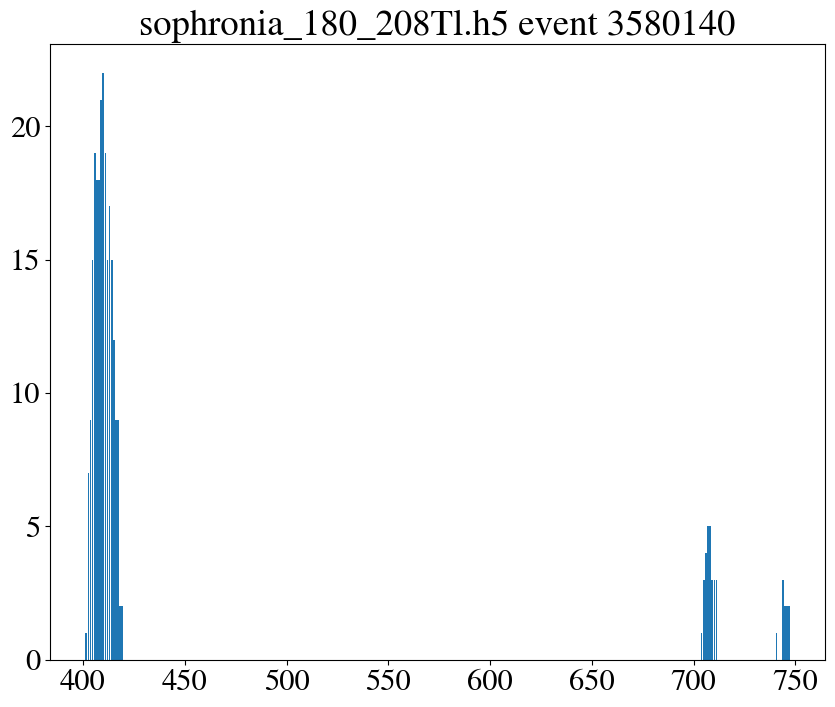

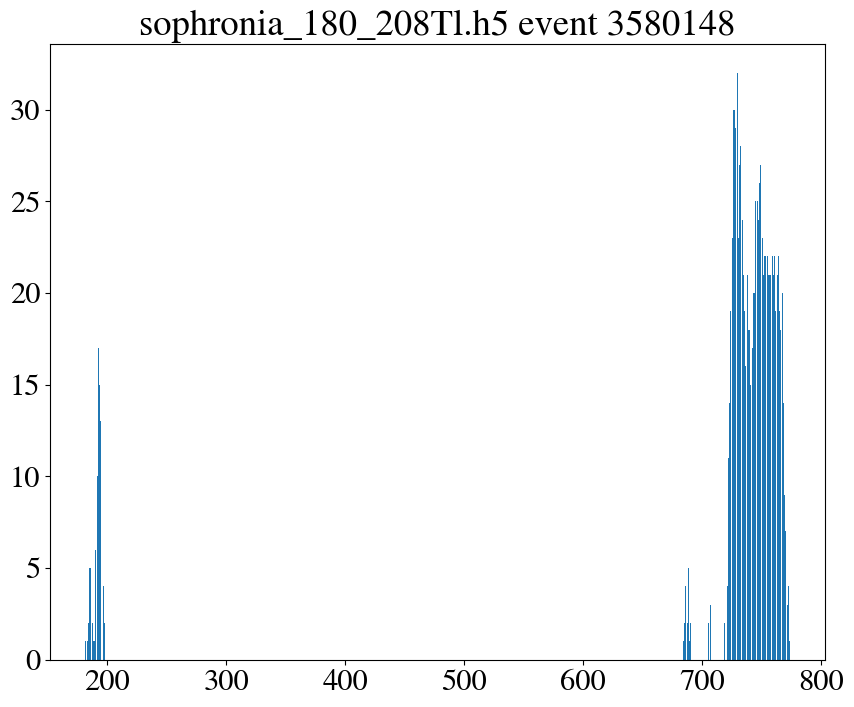

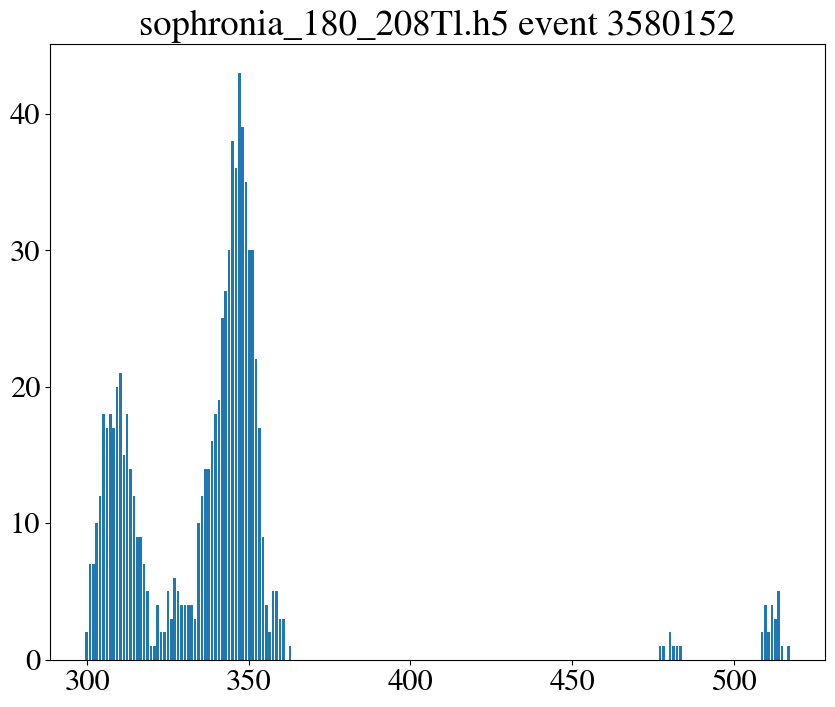

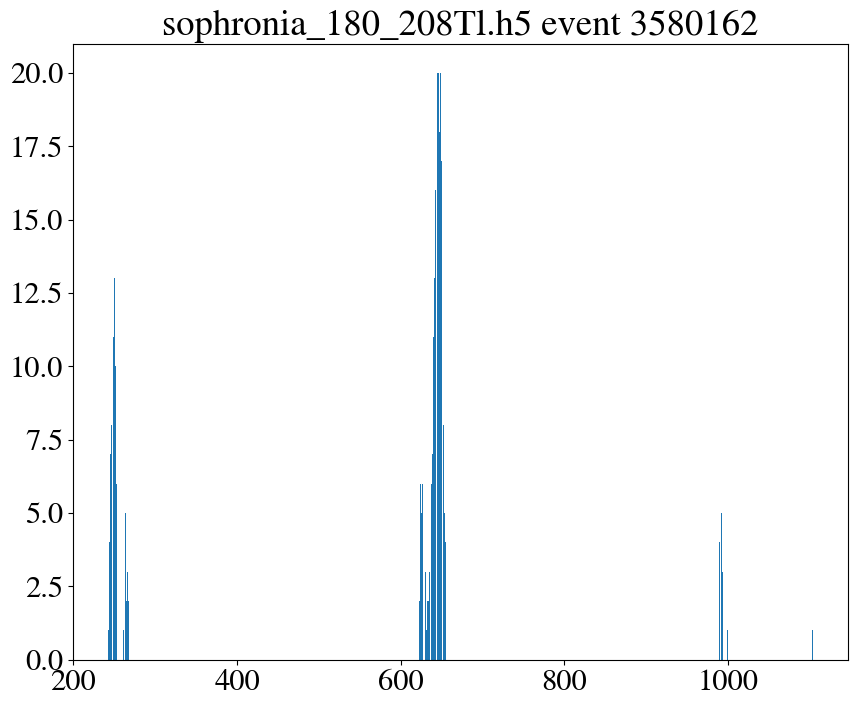

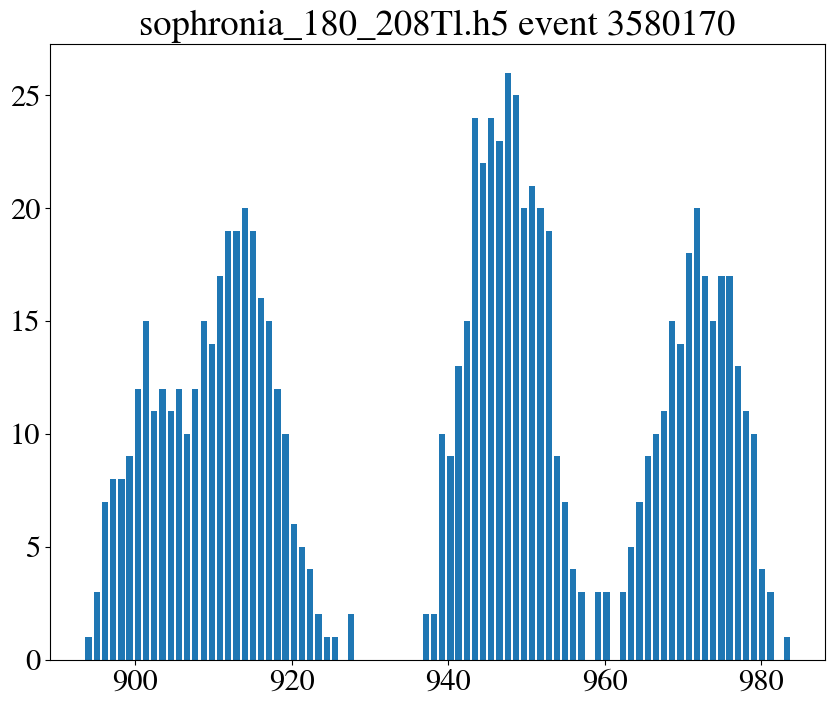

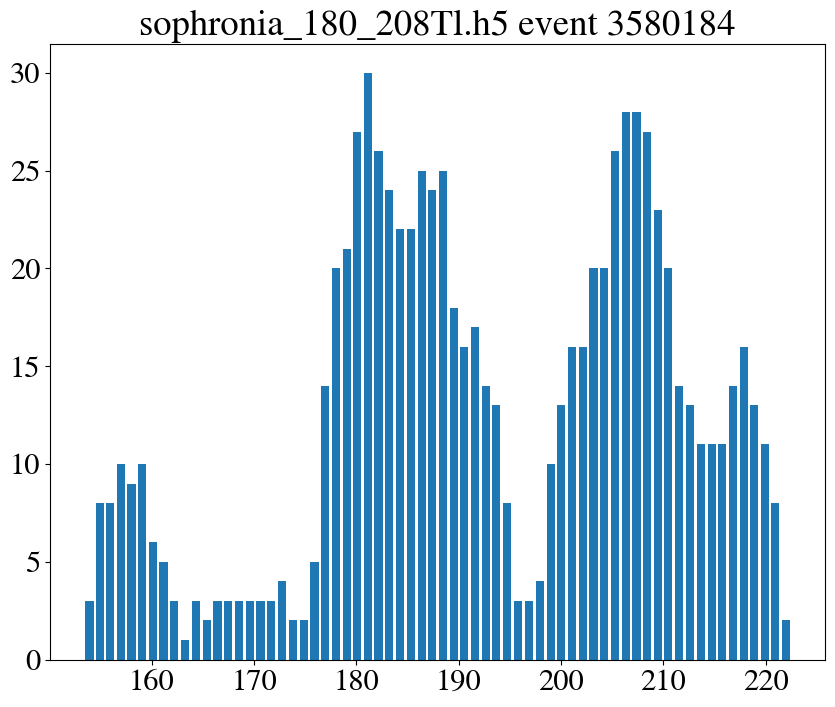

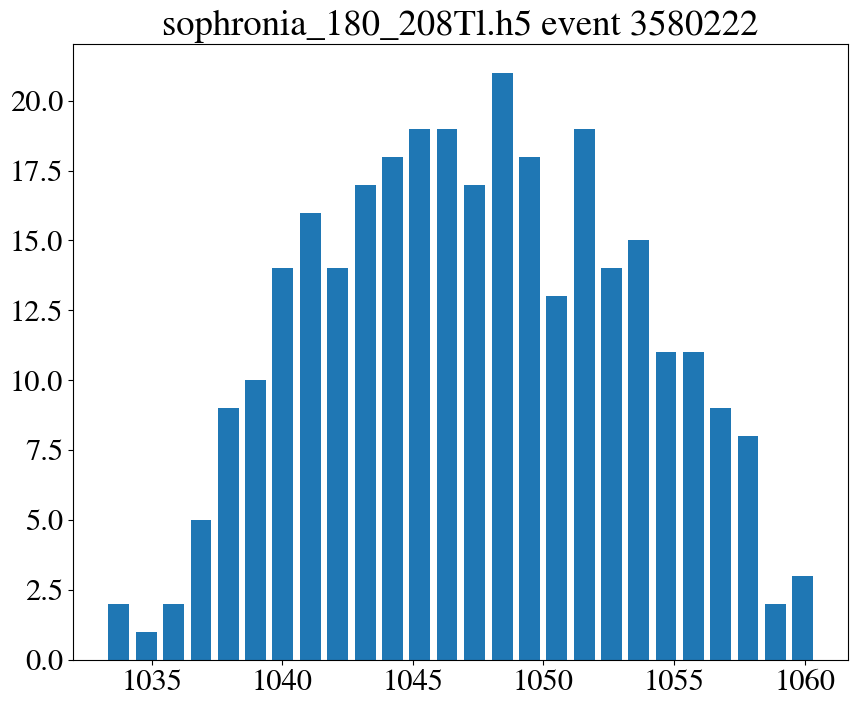

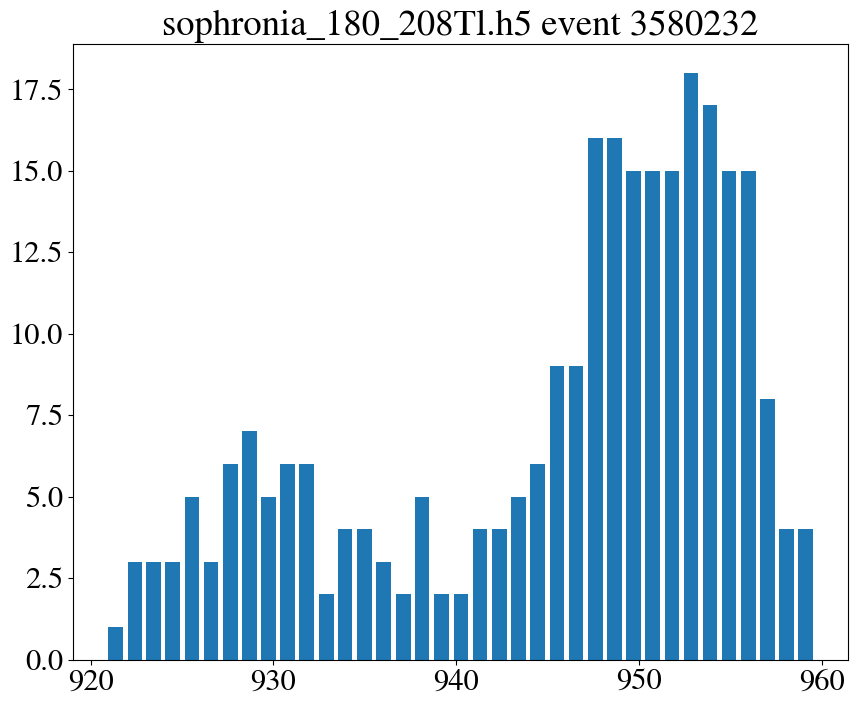

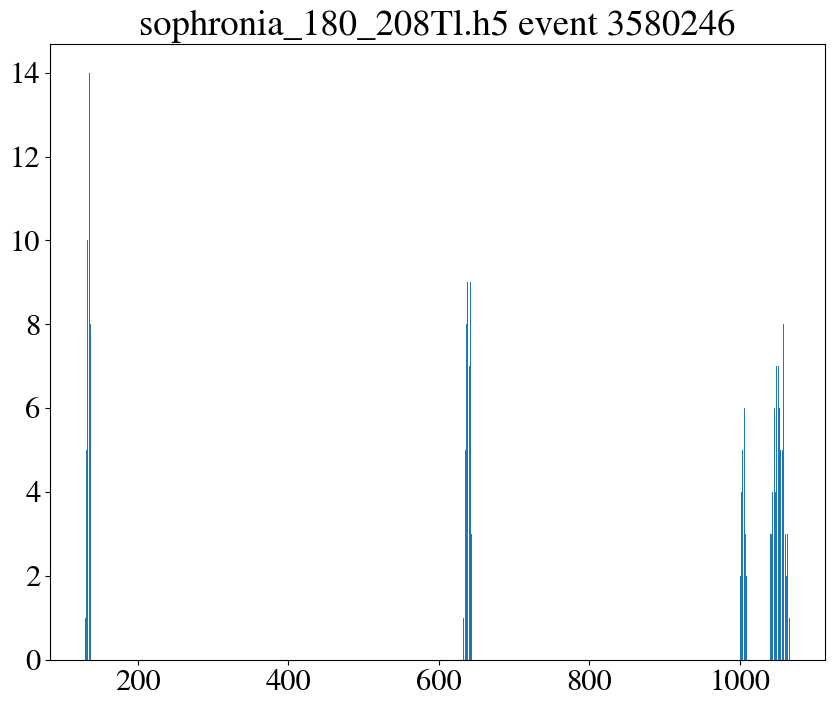

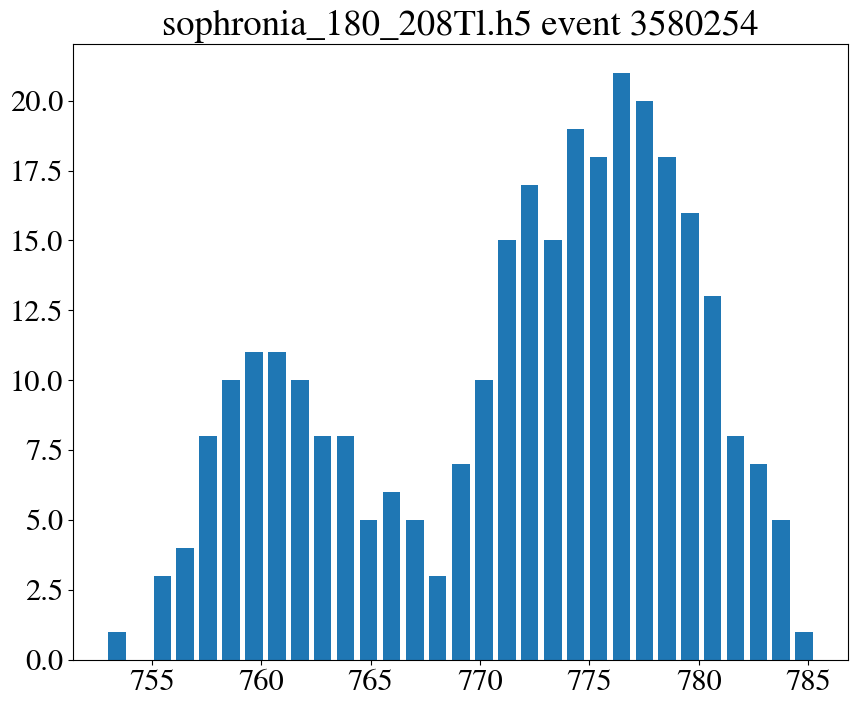

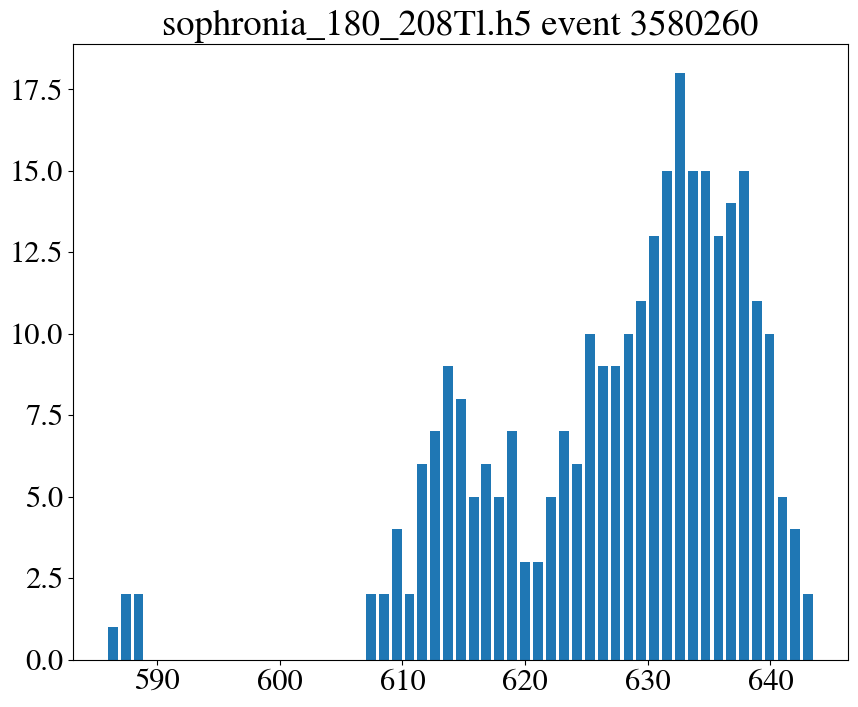

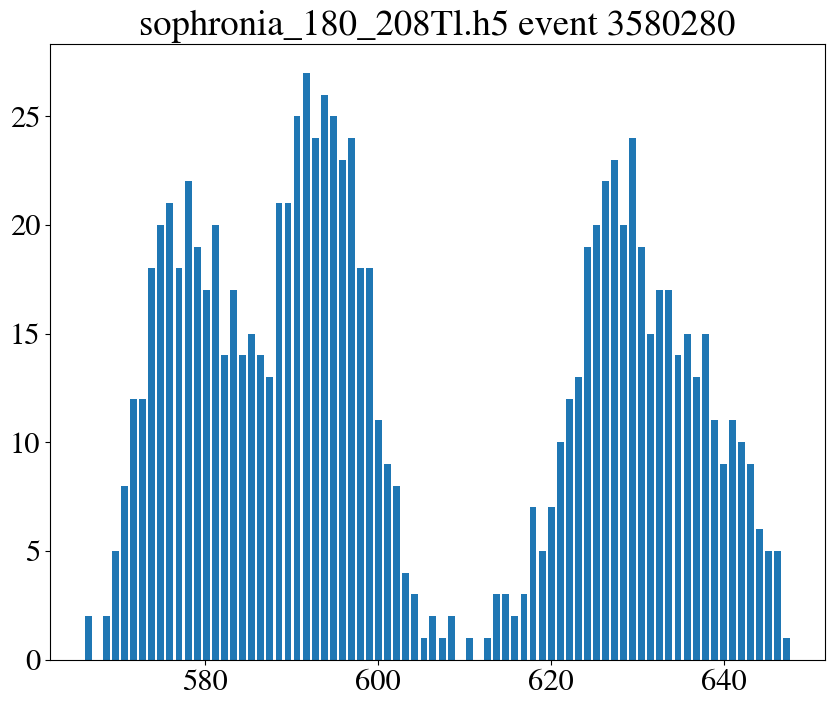

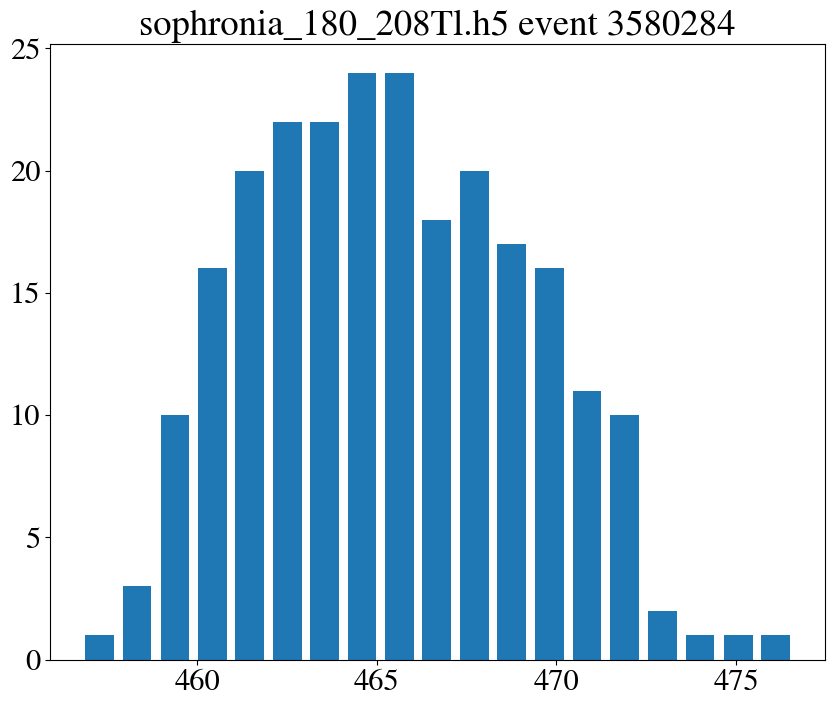

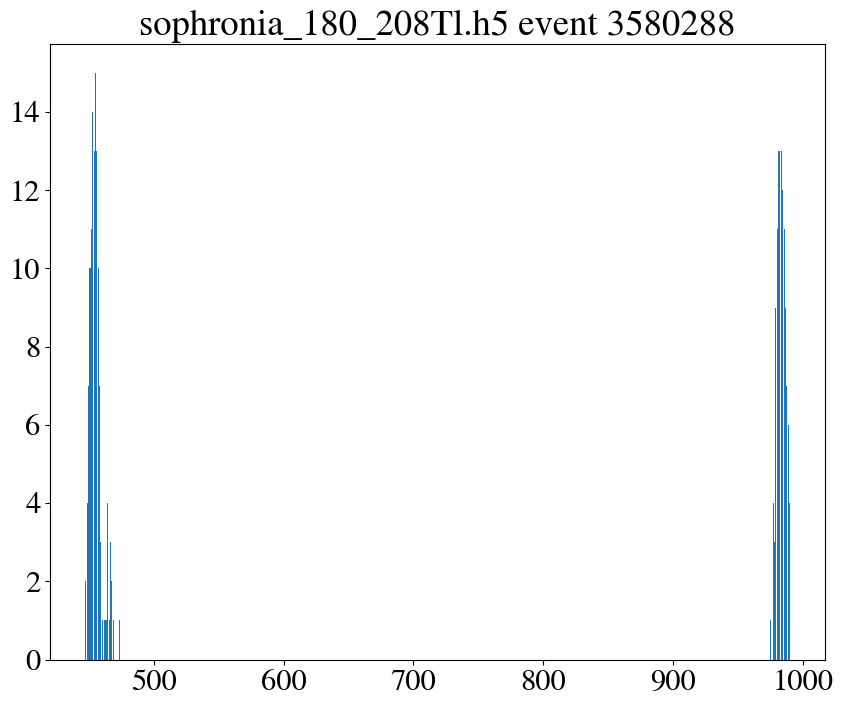

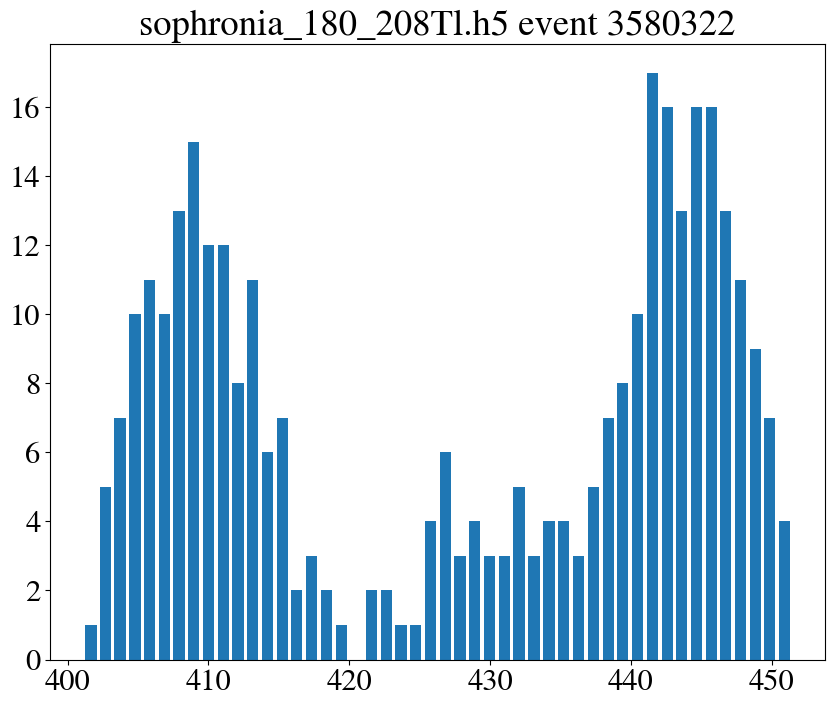

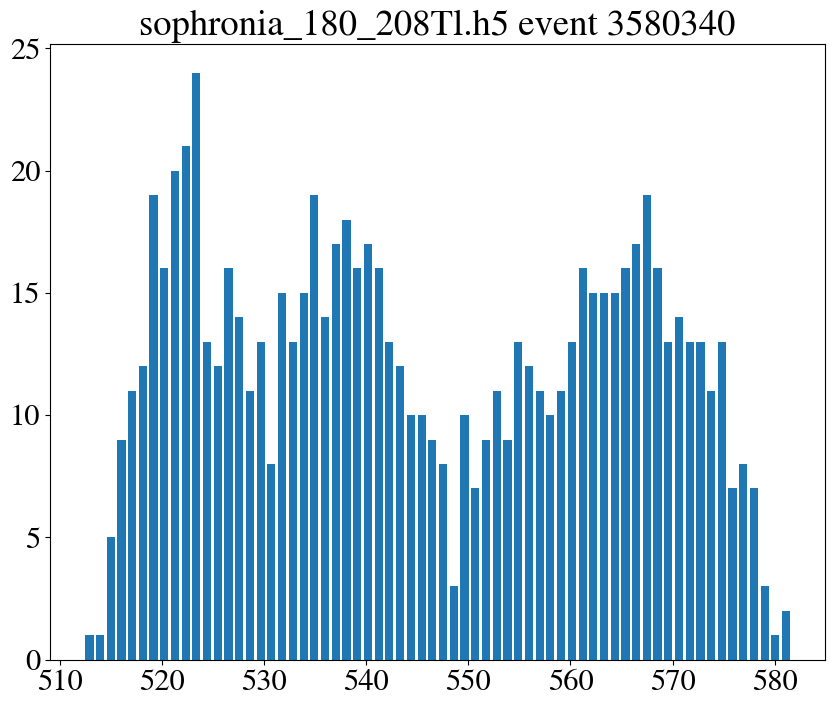

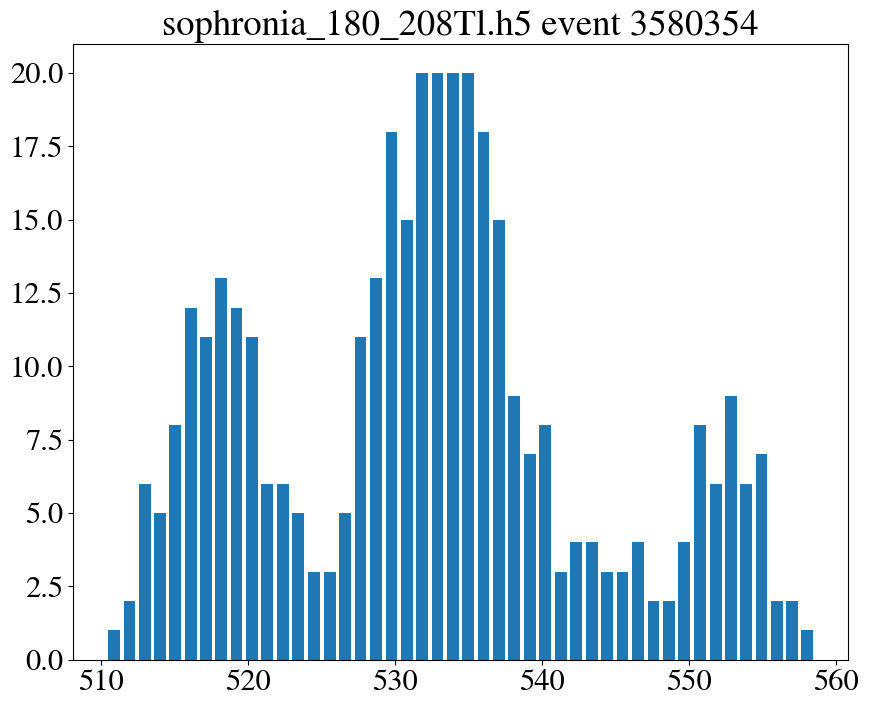

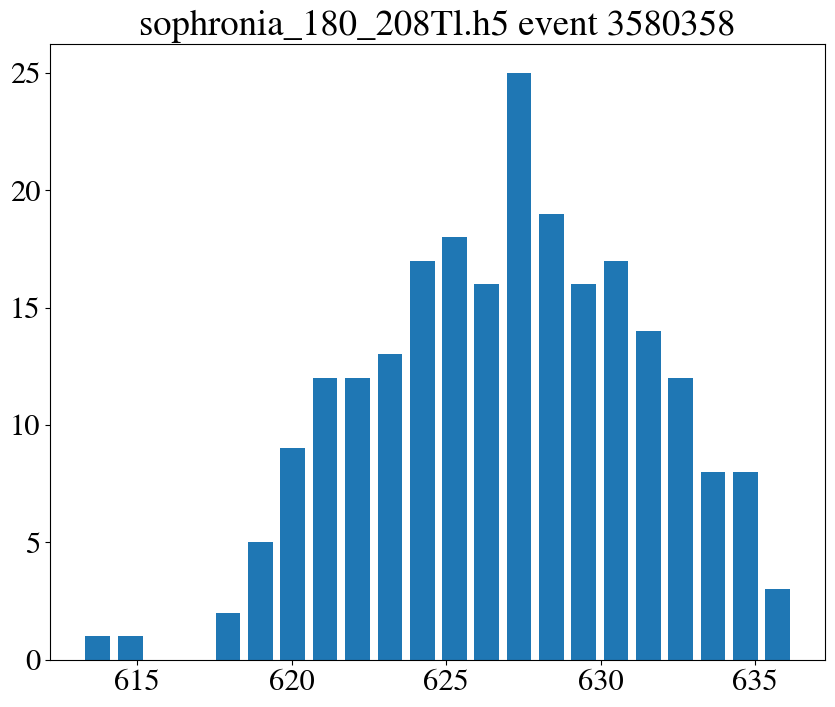

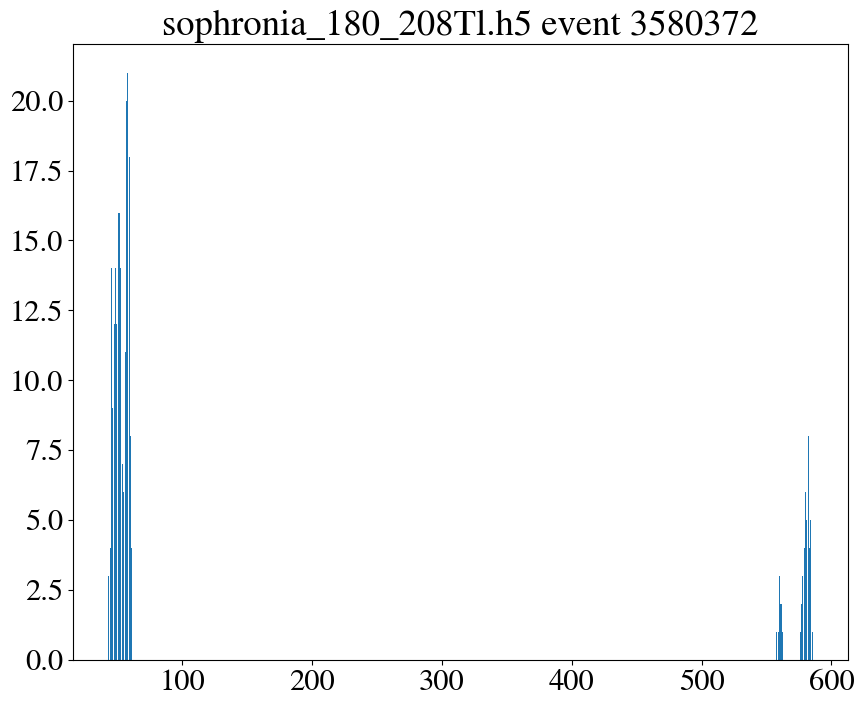

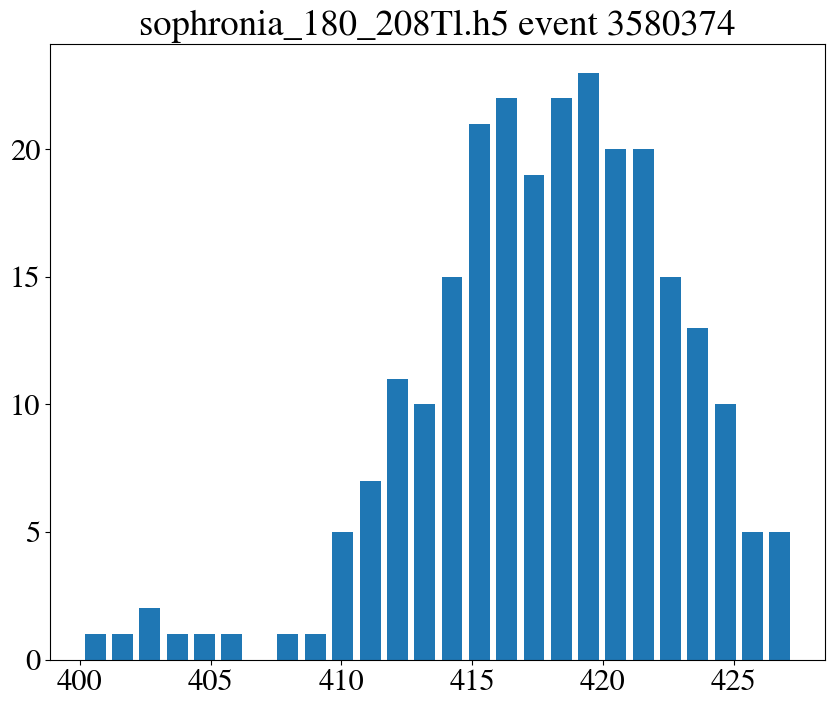

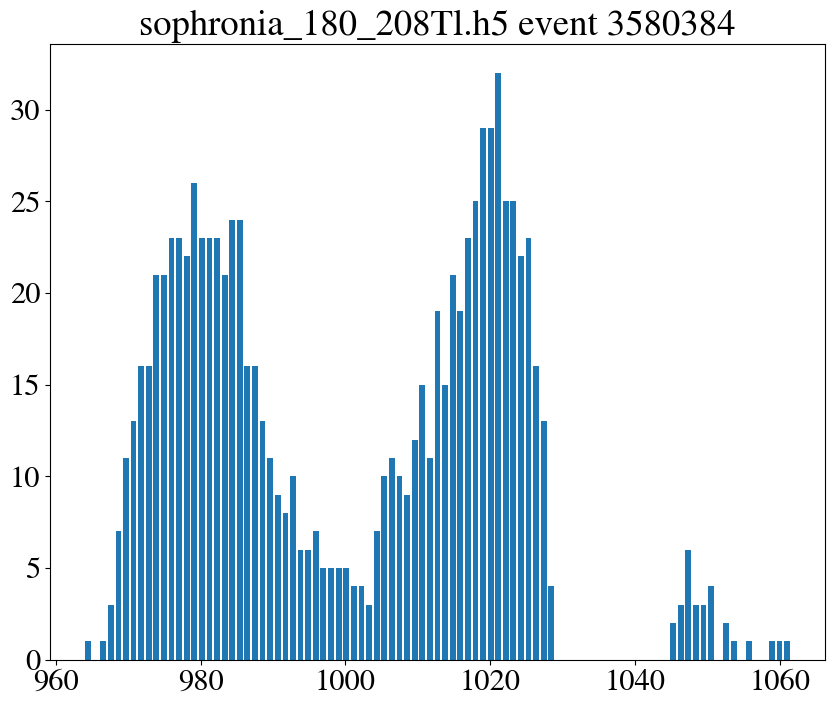

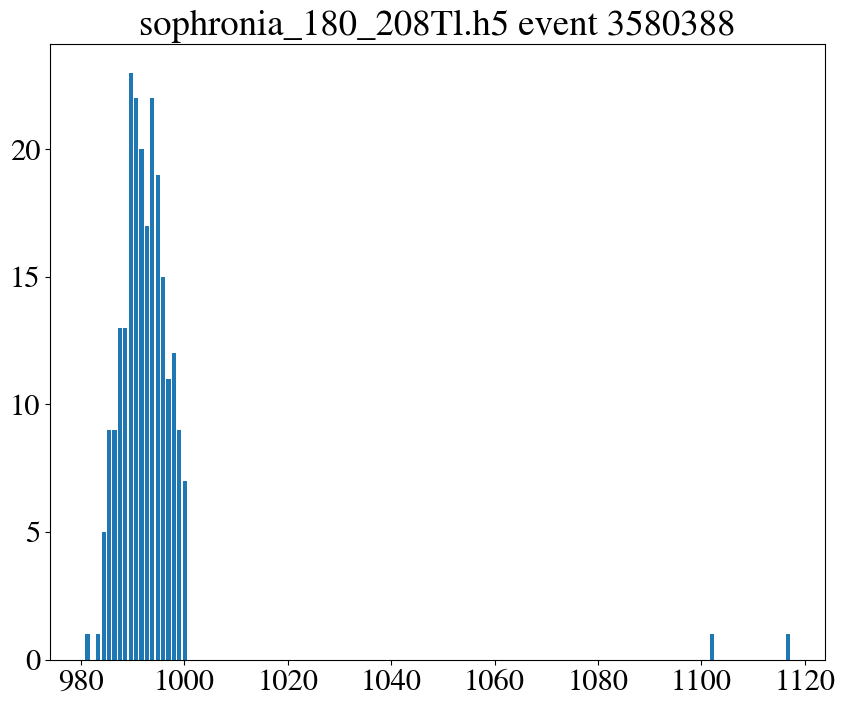

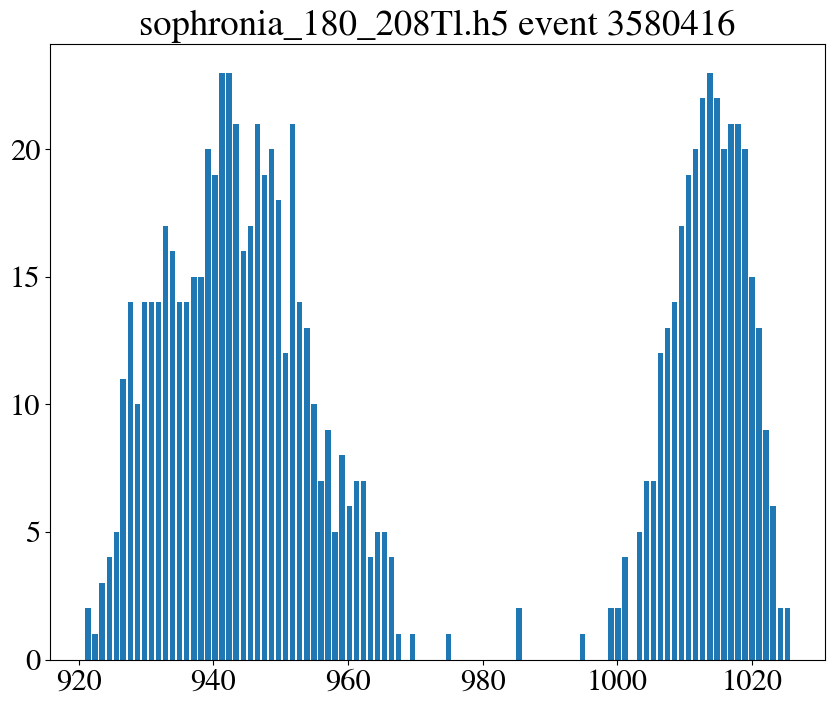

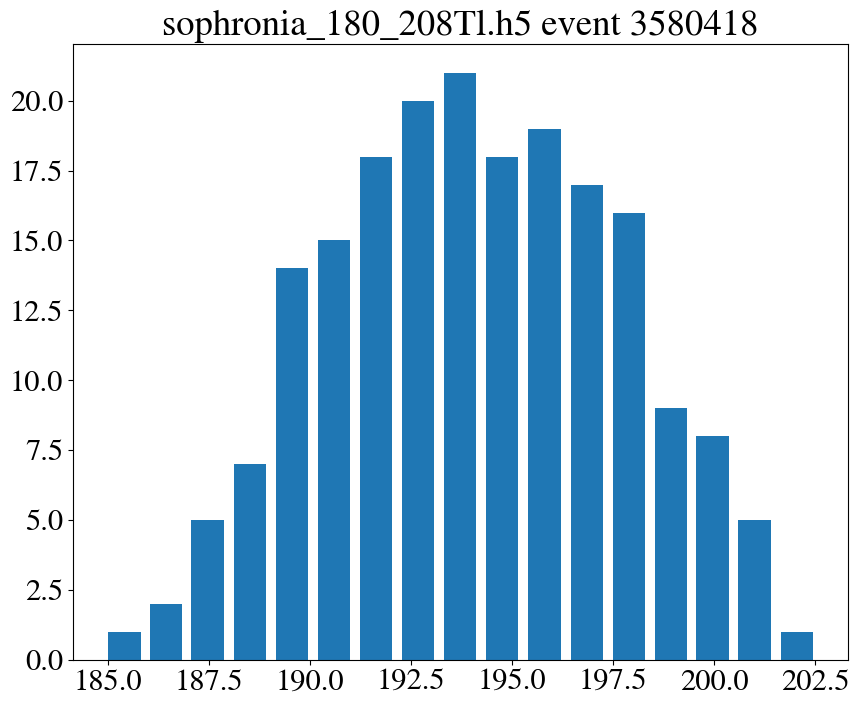

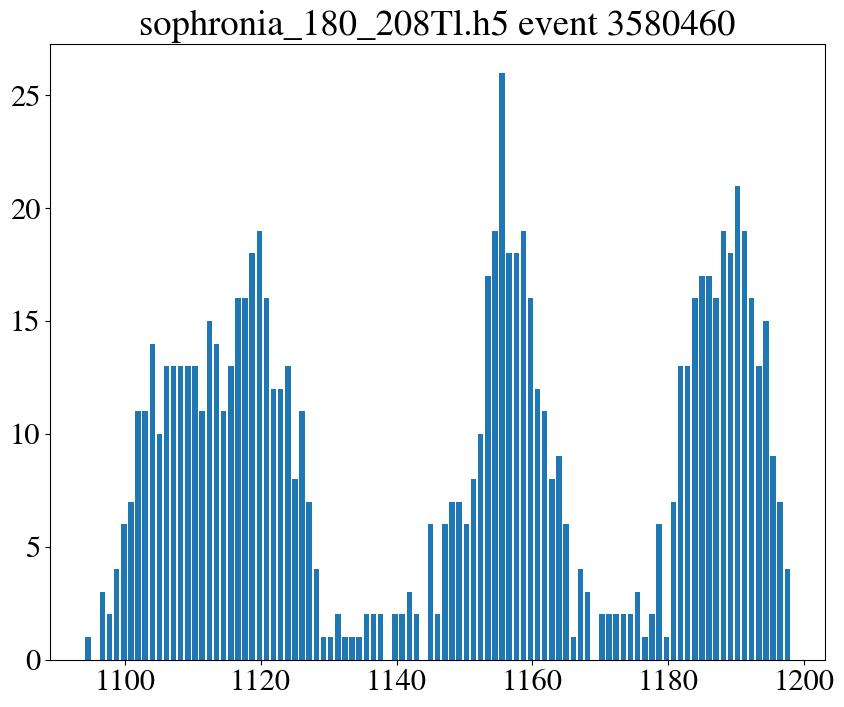

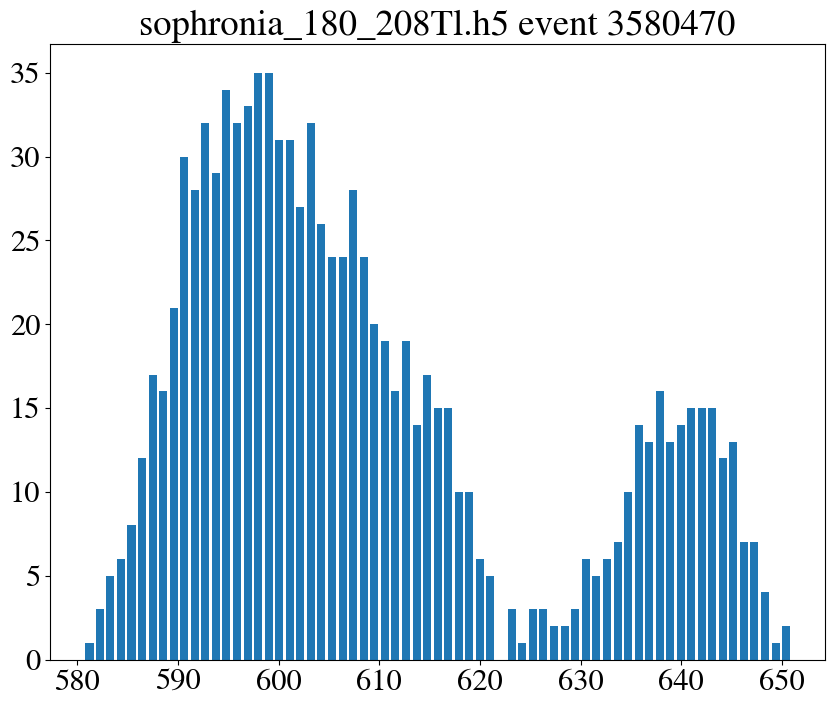

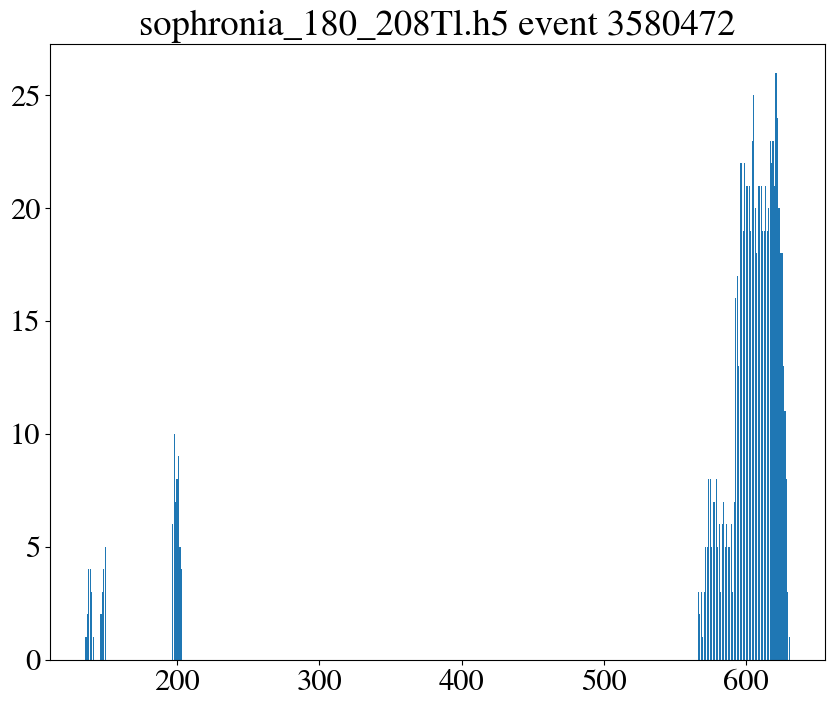

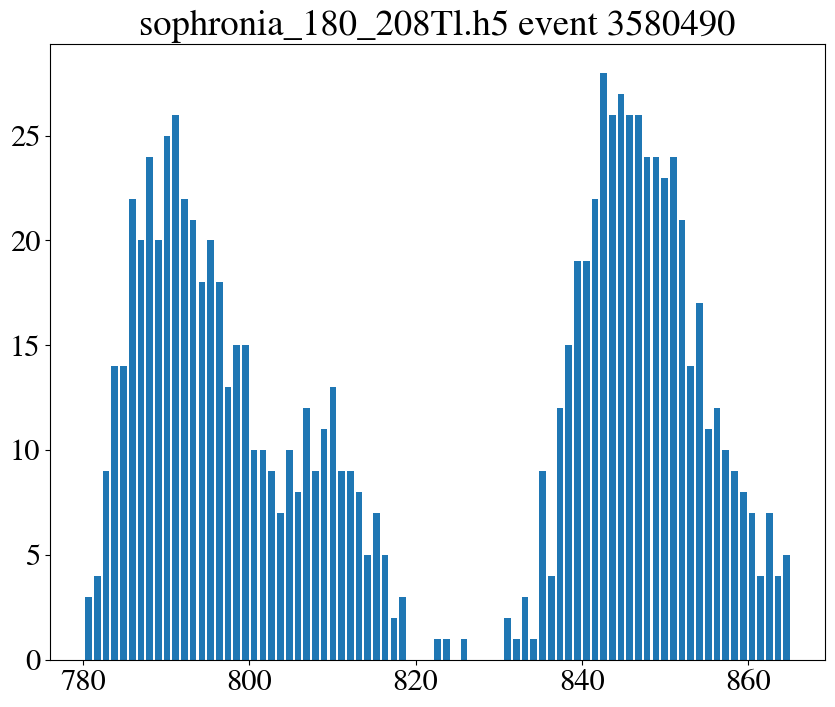

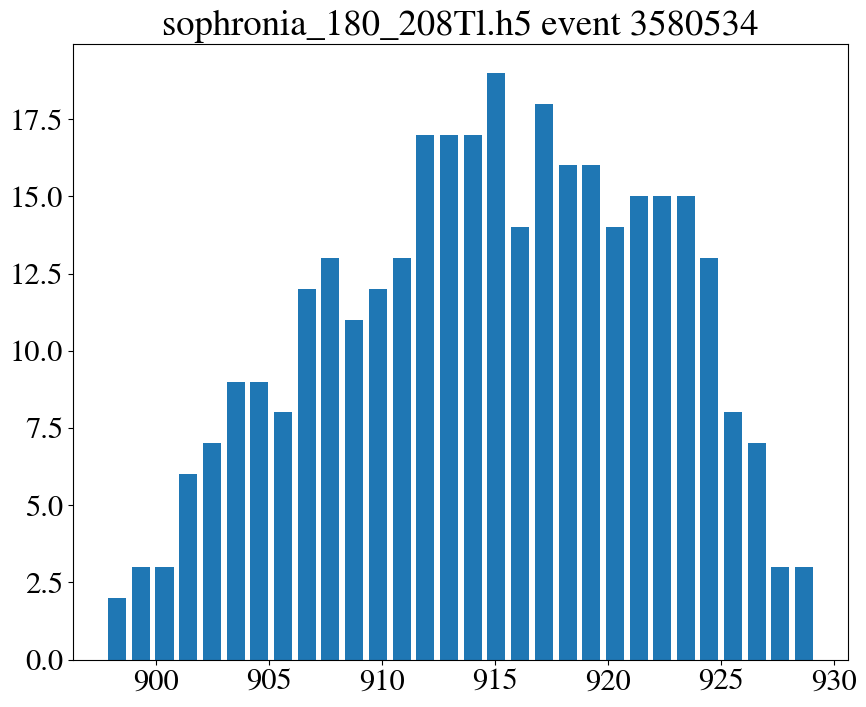

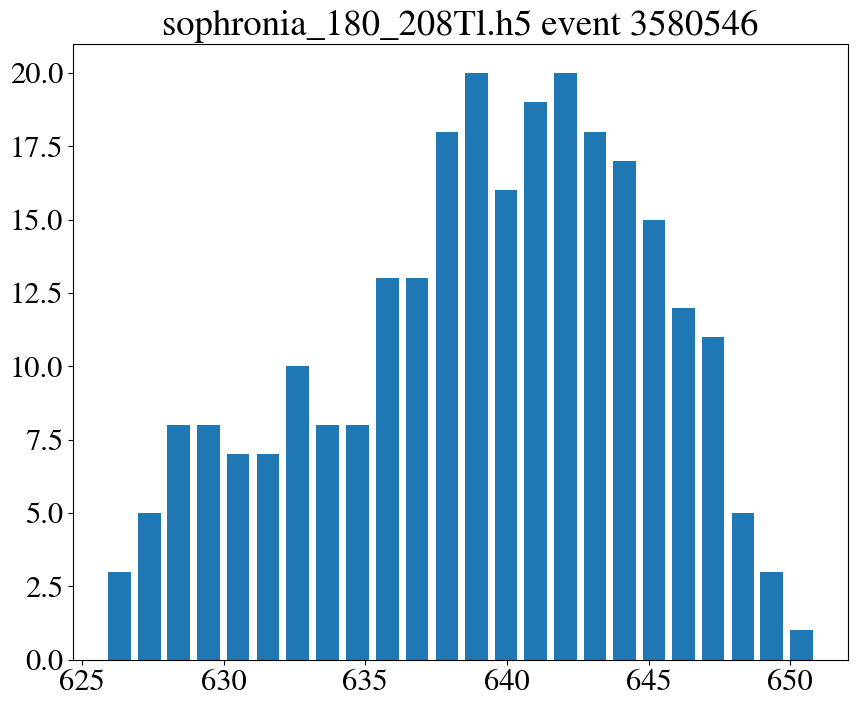

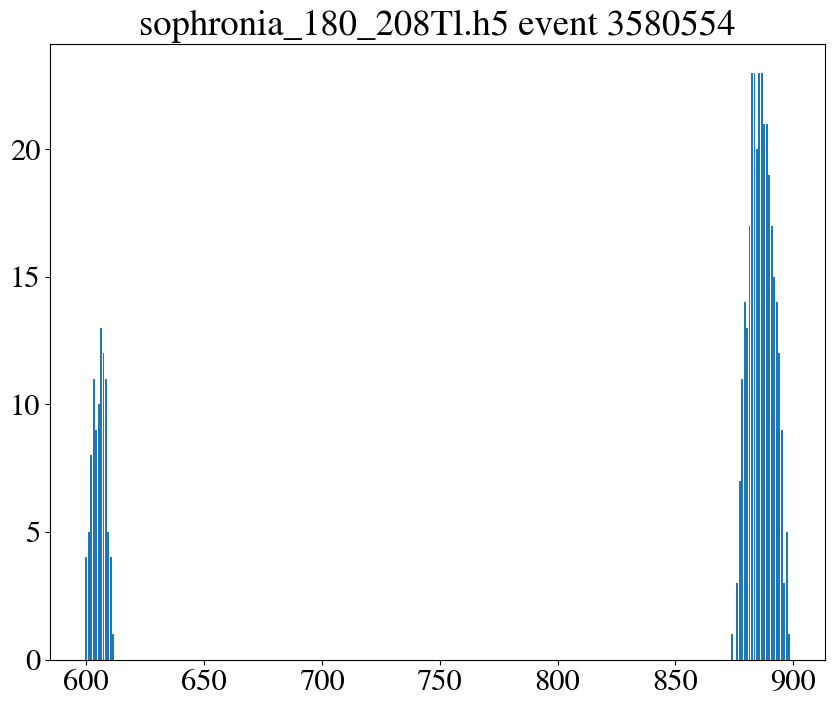

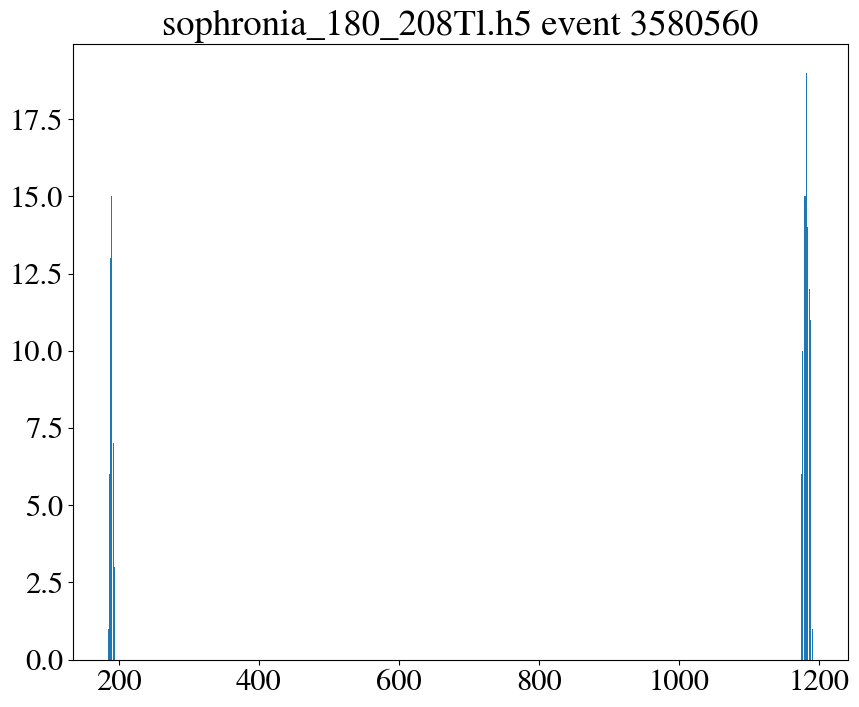

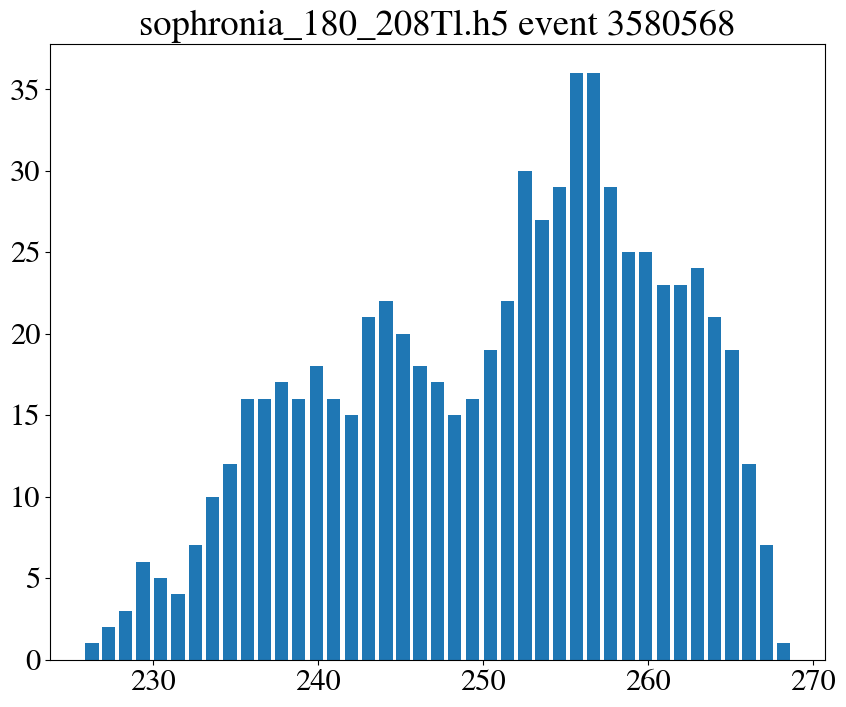

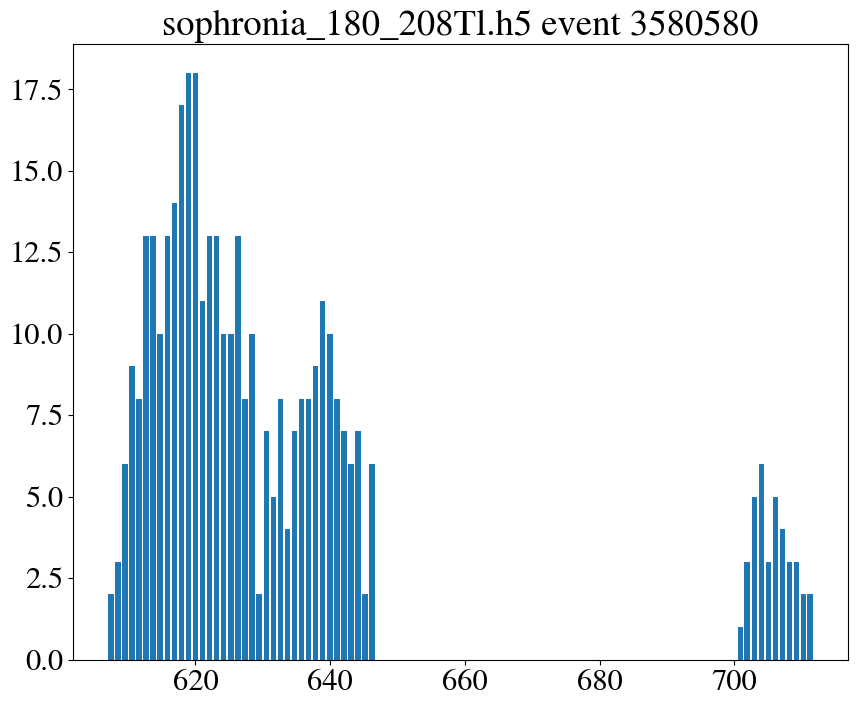

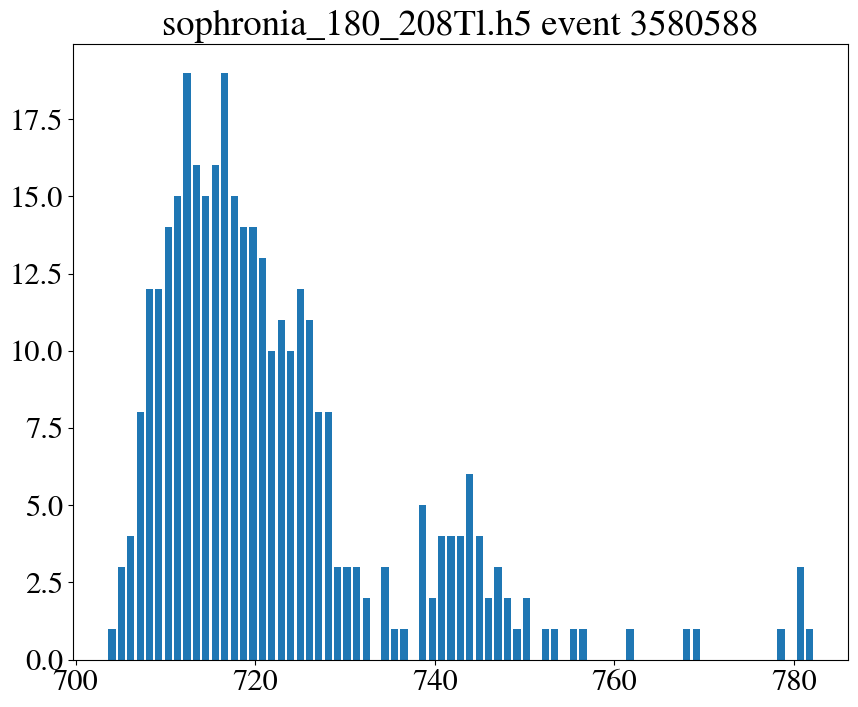

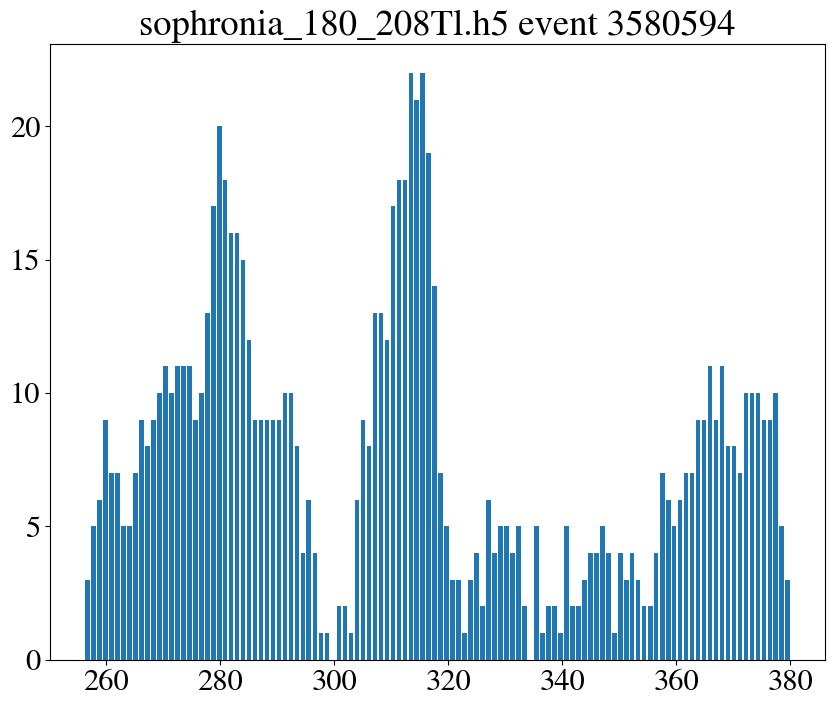

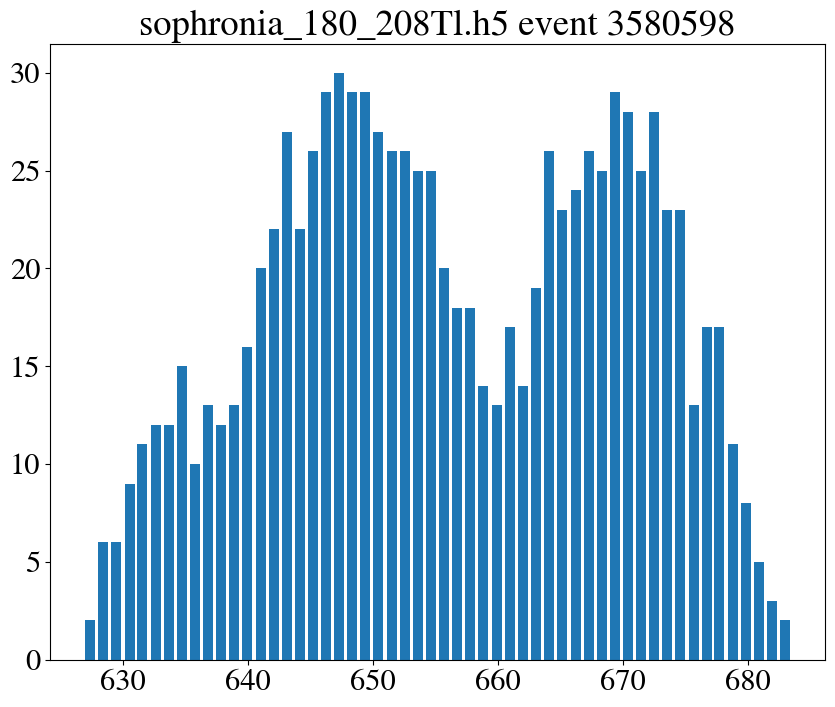

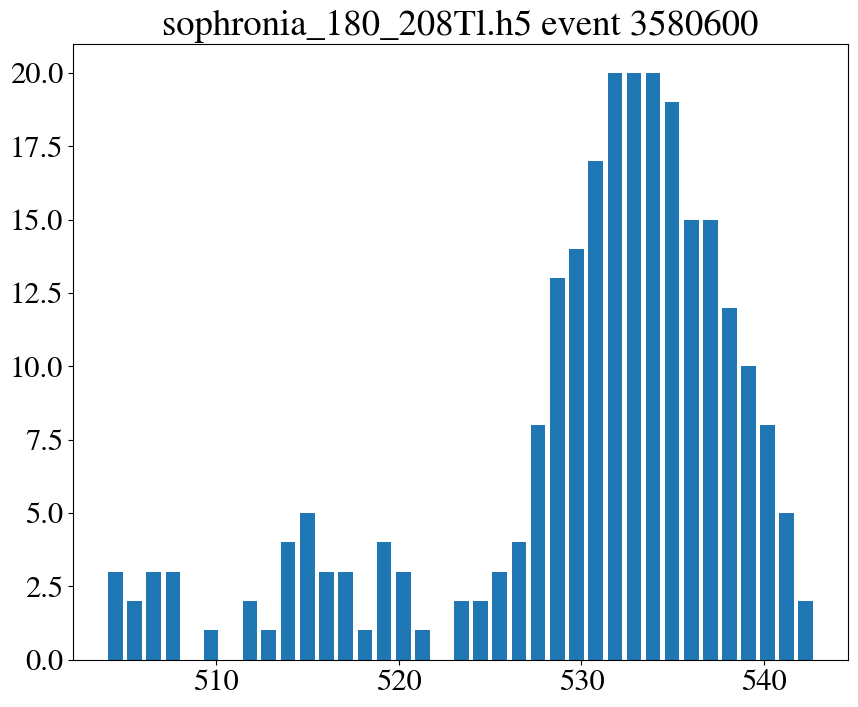

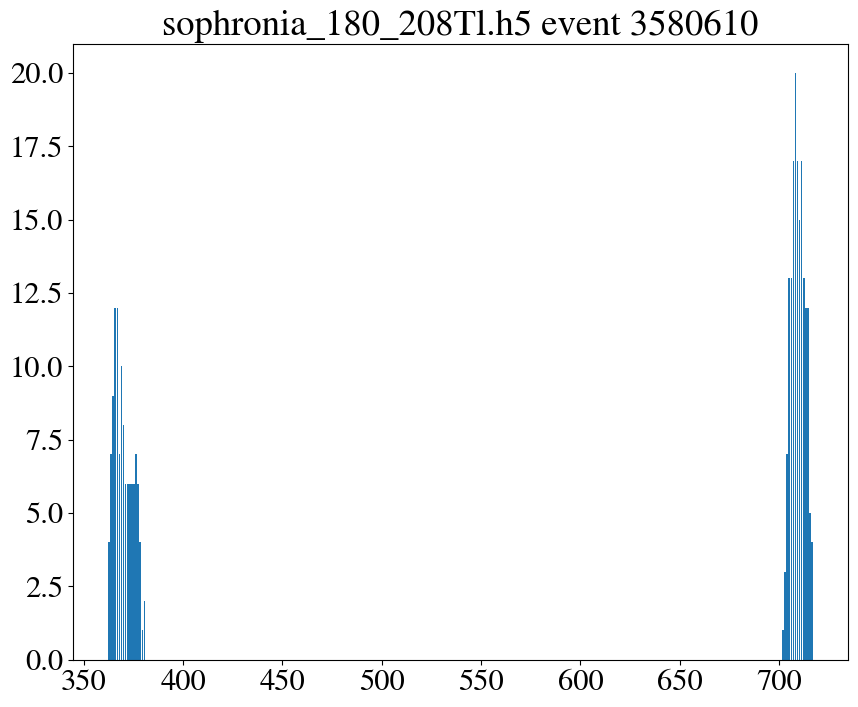

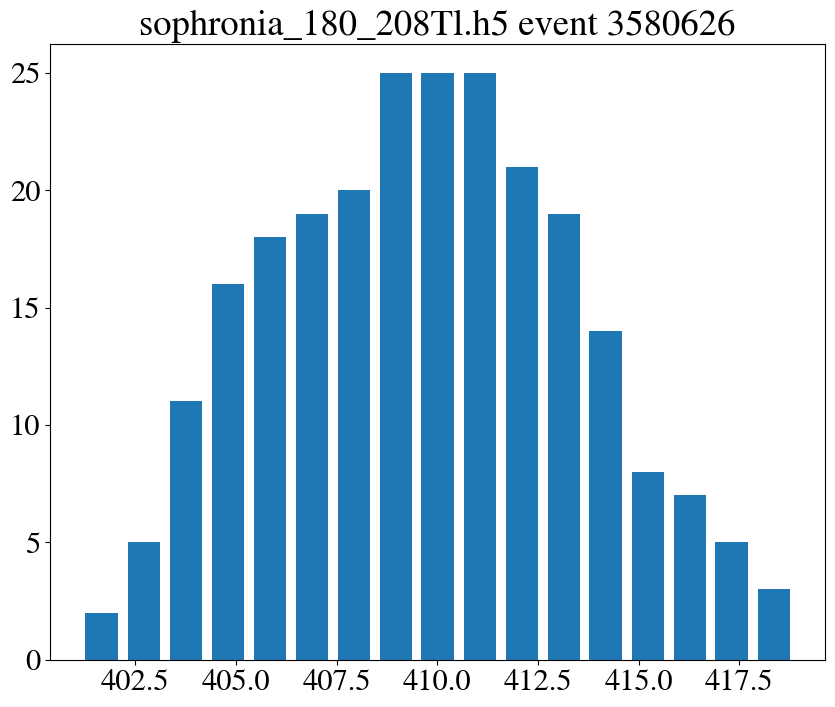

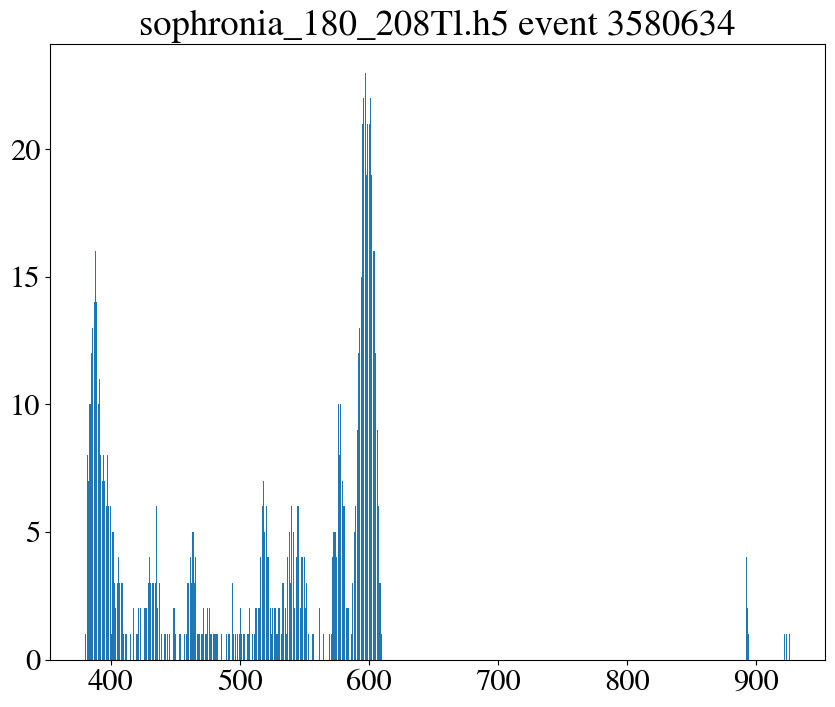

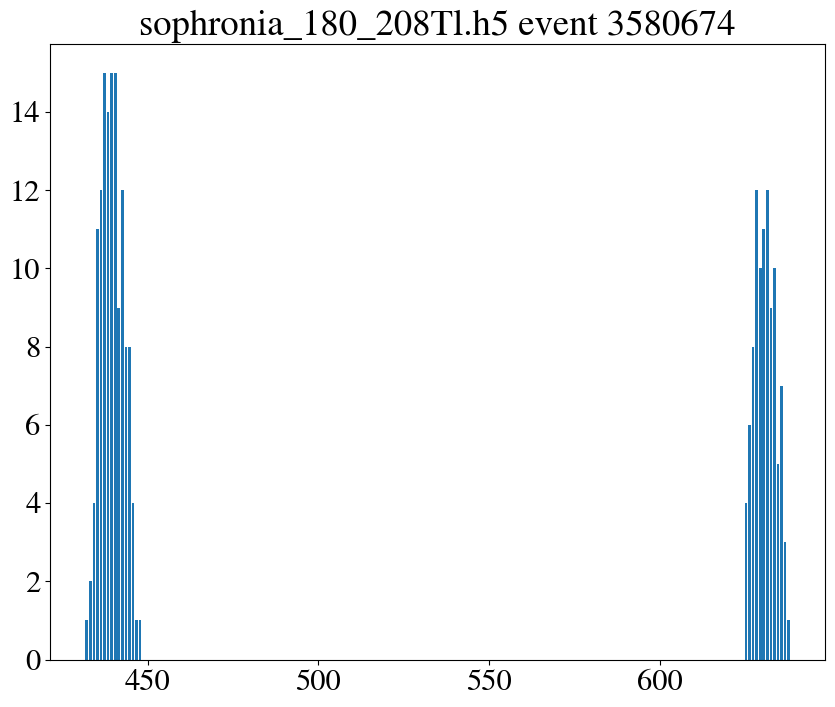

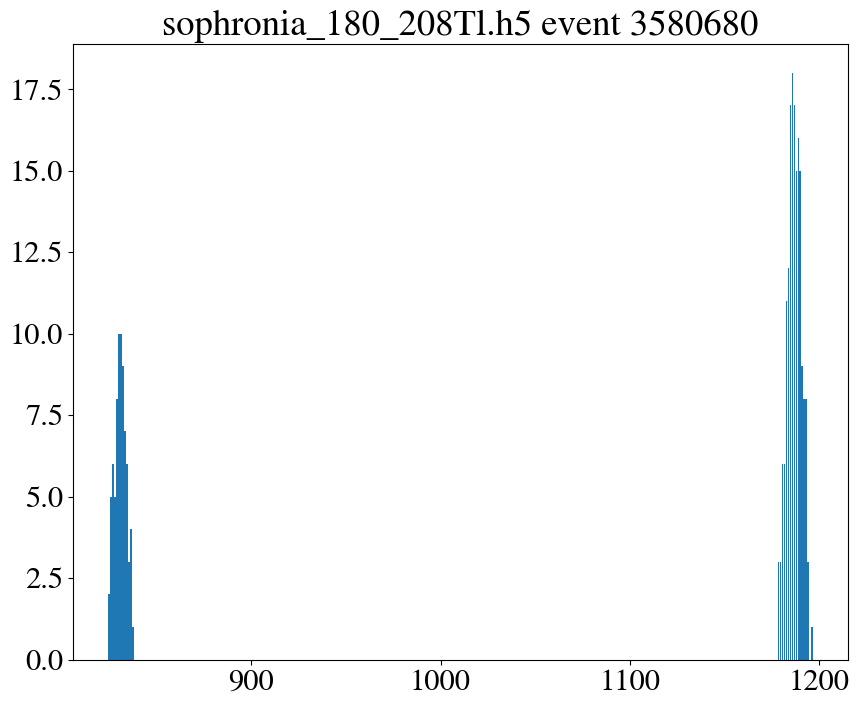

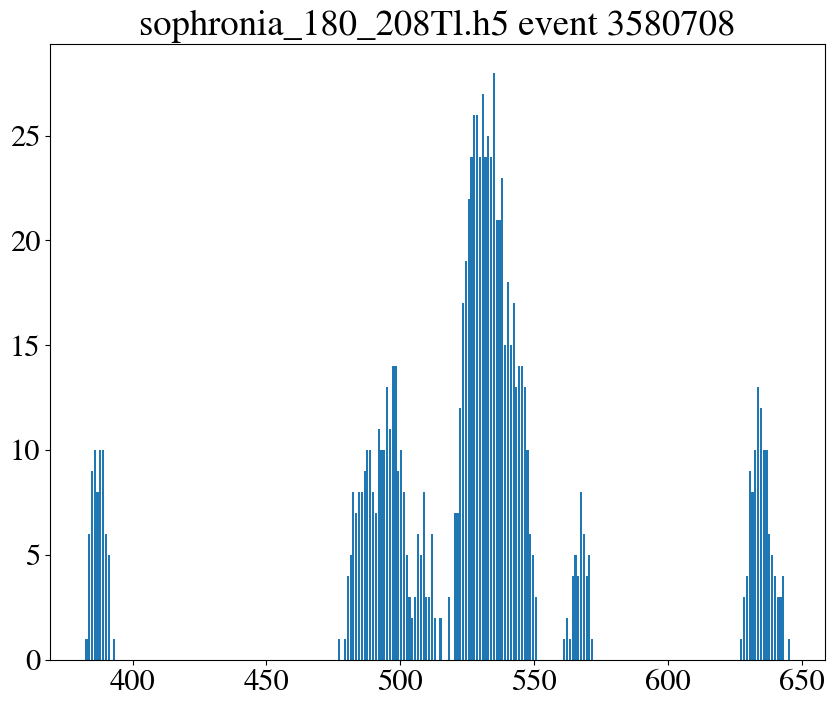

In [19]:
for i in range(len(posi_events)):
    q +=1
    if (q == limit):
        break
    
    evt  = posi_events[i]
    
    soph_evt = soph_hdst[soph_hdst.event == evt]

    z_slice = soph_evt.groupby(['Z']).apply(lambda x: len(x))#E.nunique()

    plt.bar(z_slice.index, z_slice.values)
    plt.title(file + " event " + str(evt))
    plt.show()
    #